* [Yelp, Not Kaggle Data Source](https://www.yelp.com/dataset/download)
* [Data Dictionary](https://www.yelp.com/dataset/documentation/main)

* [x] Get data into csv to work in pandas
* [x] Perform sentiment classification with Hugging Face model (2024 SOTA)
* [x] Extract from text key words that resulted in sentiment class (aspect-based sentiment analysis)
* [x] topic modeling
* [ ] other advanced analytics for reviews using LLM/HuggingFace (Sentiment Classification, Named Entity Recognitiion, Radar Graph)
* [ ] compare competition side-by-side (Japanese restaurants) using Radar Graph
* [ ] get criteria for ranking/qualities in restaurant based on aggregation of common words through clustering

In [1]:
!pip install duckdb jupysql -q transformers torch bertopic pyabsa --quiet  
!python -m spacy download en_core_web_md --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kaggle-environments 1.14.3 requires scipy>=1.11.2, but you have scipy 1.10.1 which is incompatible.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
momepy 0.7.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
ydata-profiling 4.6.4 requires numpy<1.26,>=1.16.0, but you have numpy 1.26.4 which is incompatible.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [2]:
# Computation Status Bar
from tqdm.notebook import tqdm
tqdm.pandas()

# Data Processing
import json
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)

import duckdb
%load_ext sql
conn = duckdb.connect()
%sql conn --alias duckdb

import re
from collections import Counter

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# NLP Processing and Model Inference
from nltk.corpus import stopwords
import torch
import nltk

## Generate different embeddings
import tensorflow
import tensorflow_hub as hub

# Sentiment Analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer 

# Topic Modeling
import spacy
nlp = spacy.load('en_core_web_md')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from gensim import corpora
from gensim.models.ldamodel import LdaModel

from bertopic import BERTopic
from sentence_transformers import SentenceTransformer, util
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import MaximalMarginalRelevance

# Aspect Based Sentiment Analysis
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from pyabsa import ATEPCCheckpointManager

Deploy Shiny apps for free on Ploomber Cloud! Learn more: https://ploomber.io/s/signup


2024-06-18 00:27:54.176737: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-18 00:27:54.176887: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-18 00:27:54.359002: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "
/bin/sh: 1: nvidia-smi: not found


No CUDA GPU found in your device
[2024-06-18 00:29:21] (2.4.1.post1) PyABSA(2.4.1.post1): If your code crashes on Colab, please use the GPU runtime. Then run "pip install pyabsa[dev] -U" and restart the kernel.
Or if it does not work, you can use v1.x versions, e.g., pip install pyabsa<2.0 -U




Try to downgrade transformers<=4.29.0.






/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [3]:
dfr = pd.read_csv('/kaggle/input/yelp-revised/yelp_biz_rev.csv')
dfr.head()

/opt/conda/lib/python3.10/multiprocessing/pool.py:268: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=1>
  _warn(f"unclosed running multiprocessing pool {self!r}",
/tmp/ipykernel_18/3121522079.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  dfr = pd.read_csv('/kaggle/input/yelp-revised/yelp_biz_rev.csv')


,Unnamed: 0,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,attributes,categories,review_id,user_id,review_stars,text,date
0,0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80.0,"{'key': ['RestaurantsDelivery', 'OutdoorSeating', 'BusinessAcceptsCreditCards', 'BusinessParking', 'BikeParking', 'RestaurantsPriceRange2', 'RestaurantsTakeOut', 'ByAppointmentOnly', 'WiFi', 'Alcohol', 'Caters'], 'value': ['False', 'False', 'False', ""{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}"", 'True', '1', 'True', 'False', ""u'free'"", ""u'none'"", 'True']}","Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries",BXQcBN0iAi1lAUxibGLFzA,6_SpY41LIHZuIaiDs5FMKA,4.0,"This is nice little Chinese bakery in the heart of Philadelphia's Chinatown! The female cashier was very friendly (flirtatious!) and the pastries shown in nicely adorned display cases. I stopped by early one evening had a sesame ball, which was filled with bean paste. The glutinous rice of the ball was nicely flavored, similar to Bai Tang Gao. Definitely as place worth stopping at if you are in the area.",2014-05-26 01:09:53
1,1,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80.0,"{'key': ['RestaurantsDelivery', 'OutdoorSeating', 'BusinessAcceptsCreditCards', 'BusinessParking', 'BikeParking', 'RestaurantsPriceRange2', 'RestaurantsTakeOut', 'ByAppointmentOnly', 'WiFi', 'Alcohol', 'Caters'], 'value': ['False', 'False', 'False', ""{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}"", 'True', '1', 'True', 'False', ""u'free'"", ""u'none'"", 'True']}","Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries",uduvUCvi9w3T2bSGivCfXg,tCXElwhzekJEH6QJe3xs7Q,4.0,"This is the bakery I usually go to in Chinatown. They have a decent variety of buns and pastries. Red bean-filled buns, mung bean-filled buns, coconut stuff, egg tarts etc. If you buy a dozen, they will give you two more for free. The prices are standard for a Chinese bakery, with most things at approximately $1. The service has always been good. They do serve coffee and tea. There are a couple of tables inside, with usually the expected group of older Chinese guys chillin' in the corner table debating about something. Great place to stock up on the buns, which I usually do before leaving town.",2013-10-05 15:19:06
2,2,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80.0,"{'key': ['RestaurantsDelivery', 'OutdoorSeating', 'BusinessAcceptsCreditCards', 'BusinessParking', 'BikeParking', 'RestaurantsPriceRange2', 'RestaurantsTakeOut', 'ByAppointmentOnly', 'WiFi', 'Alcohol', 'Caters'], 'value': ['False', 'False', 'False', ""{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}"", 'True', '1', 'True', 'False', ""u'free'"", ""u'none'"", 'True']}","Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries",a0vwPOqDXXZuJkbBW2356g,WqfKtI-aGMmvbA9pPUxNQQ,5.0,"A delightful find in Chinatown! Very clean, and very kind service. Everyone always seems happy in here, and their treats are absolutely delicious. You can also get a ton of sweet treats without any judgement! They're my favorite.",2013-10-25 01:34:57
3,3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80.0,"{'key': ['RestaurantsDelivery', 'OutdoorSeating', 'BusinessAcceptsCreditCards', 'BusinessParking', 'BikeParking', 'RestaurantsPriceRange2', 'RestaurantsTakeOut', 'ByAppointmentOnly', 'WiFi', 'Alcohol', 'Caters'], 'value': ['False', 'False', 'False', ""{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}"", 'True', '1', 'True', 'False', ""u'free'"", ""u'none'"", 'True']}","Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries",MKNp_CdR2k2202-c8GN5Dw,3-1va0IQfK-9tUMzfHWfTA,5.0,I ordered a graduation cake for my niece and 

In [4]:
# dfr['categories'].value_counts()[:20]                                                                           

In [5]:
# Need to clean up category data

query = """
select business_id
, name
, address
, city
, state
, postal_code
, latitude
, longitude
, stars
, review_count
, attributes
, case when categories = 'Mexican, Restaurants' then 'Restaurants, Mexican'
when categories = 'Pizza, Restaurants' then 'Restaurants, Pizza'
when categories = 'Chinese, Restaurants' then 'Restaurants, Chinese'
when categories = 'Italian, Restaurants' then 'Restaurants, Italian'
when categories = 'Thai, Restaurants' then 'Restaurants, Thai'
when categories = 'Seafood, Restaurants' then 'Restaurants, Seafood'
when categories = 'American (New), Restaurants' then 'Restaurants, American (New)'
when categories = 'Thai, Restaurants' then 'Restaurants, Thai'
when categories = 'Seafood, Restaurants' then 'Restaurants, Seafood'
when categories = 'Vietnamese, Restaurants' then 'Restaurants, Vietnamese'
when categories = 'Cajun/Creole, Restaurants' then 'Restaurants, Cajun/Creole'
else categories
end as categories
, review_id
, user_id
, review_stars
, text
, date
from dfr
"""

dfr = duckdb.query(query).df()
dfr['categories'].value_counts()[:20]

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

categories
Restaurants, Mexican                                                                                     88958
Restaurants, Pizza                                                                                       49803
Restaurants, Chinese                                                                                     40040
Restaurants, Italian                                                                                     39086
Restaurants, Thai                                                                                        23803
Restaurants, American (New)                                                                              22206
Restaurants, Seafood                                                                                     20771
Restaurants, Vietnamese                                                                                  15508
Restaurants, Cajun/Creole                                                                            

In [6]:
# dfr['categories'].value_counts()[:20]

In [7]:
query = """
select review_id
, review_stars
, text
from dfr
"""

df_sent2 = duckdb.query(query).df()
df_sent2

,review_id,review_stars,text
0,BXQcBN0iAi1lAUxibGLFzA,4.0,"This is nice little Chinese bakery in the heart of Philadelphia's Chinatown! The female cashier was very friendly (flirtatious!) and the pastries shown in nicely adorned display cases. I stopped by early one evening had a sesame ball, which was filled with bean paste. The glutinous rice of the ball was nicely flavored, similar to Bai Tang Gao. Definitely as place worth stopping at if you are in the area."
1,uduvUCvi9w3T2bSGivCfXg,4.0,"This is the bakery I usually go to in Chinatown. They have a decent variety of buns and pastries. Red bean-filled buns, mung bean-filled buns, coconut stuff, egg tarts etc. If you buy a dozen, they will give you two more for free. The prices are standard for a Chinese bakery, with most things at approximately $1. The service has always been good. They do serve coffee and tea. There are a couple of tables inside, with usually the expected group of older Chinese guys chillin' in the corner table debating about something. Great place to stock up on the buns, which I usually do before leaving town."
2,a0vwPOqDXXZuJkbBW2356g,5.0,"A delightful find in Chinatown! Very clean, and very kind service. Everyone always seems happy in here, and their treats are absolutely delicious. You can also get a ton of sweet treats without any judgement! They're my favorite."
3,MKNp_CdR2k2202-c8GN5Dw,5.0,I ordered a graduation cake for my niece and it came out absolutely perfect. Will come again for future events! Staff was nice also and the cake was really good.
4,D1GisLDPe84Rrk_R4X2brQ,4.0,"HK-STYLE MILK TEA: FOUR STARS\n\nNot quite sure why there are two Saint Honore Pastries business listings on Yelp, but I have been checking in to this one.\n\nBoyfriend and I go by it all the time while in Chinatown, but it never crossed our mind to try it. I think we might have tried it once a year or two ago, but it wasn't memorable. I decided to try the HK-style milk tea not too long ago and was hooked. I think I went here almost every day one week to get the milk tea, only to realize that I should REALLY watch my sugar intake...it's sooo good! \n\nI personally don't think it's better than Zhong Gang's HK-style milk tea because they have their off days when a certain lady makes them (not enough ice, too much ice, etc.).\n\nOn a side note: I wanted to try the crispy roast pork bun, but accidentally said the wrong name in Chinese and got the roast pork bun. It was decent enough, although I will get to trying the crispy roast pork bun soon! \n\nI will be back~"
...,...,...,...
3773767,Kt3gFeW1rhZz7RuiV-6Tcw,5.0,"This is my favorite food truck! I only wish I lived closer to Philly so that I could eat here more often. The prices are affordable, the portions are generous, the staff is friendly, and the food is AMAZING. \n\nThe last time I went to the Plum Pit, I ordered a jerk chicken sandwich to split with a friend. Learn from our mistake--order your own sandwich, and if you can't finish it, save half for later. We ended up going back for another sandwich (the one with chicken tenders, mac & cheese, and bacon--I can't remember the name) anyway. We also got two orders of bread pudding to bring home, which, though pretty good cold, is ever better when you heat it up in the oven for 10-15 minutes."
3773768,ruy3Ycey_gGbwkE_3TX1Fg,5.0,"This food truck was stupid. Stupidly delicious. \n\nShould be a 4.5 because they were a little slow compared to other trucks, but once the food showed up, totally ON POINT.\n\nWe had the bacon Mac and cheese with the French fry bowl, topped with jerk chicken. I could not get enough of the jerk chicken. And the bacon Mac and cheese was super creamy ( again 4.5 we saw a big can of nacho cheese instead of good cheese "" . \n\nWould definitely eat here again if they were at the Stables."
3773769,C_l8NTpvNOEUorEmEOusaA,5.0,Bubba never disappoints i go to his fb page and hunt him down and now i have my friends and family stalking him too. One of the main r

In [8]:
# reduce file size by getting sample
#sample 500,000 to use less RAM
sample = df_sent2.sample(n=500000)
len(sample)

500000

In [9]:
# sample.head(1)

# Text Pre-Processing

In [10]:
# text column needs to be changed to string...
sample['text'] = sample['text'].apply(str)

In [11]:
# Get code to clean text: remove HTML tags
def cleanhtml(x): 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', x) 
    return cleantext.replace('\n\n', ' ').replace('\n', '')
    
sample['clean_text'] = sample.apply(lambda row: cleanhtml(row['text']), axis=1)

# Examine sample of dirty comments to see if translation went through
sample

,review_id,review_stars,text,clean_text
1509063,hb1tRLog8xHVc9fpyy8sJg,3.0,"I gave a 3 because the food didn't taste bad. My rating is the size of the items vs price. This was the BLT I got for $6.95, (just the sandwich, no fries or chips). Bread was grilled, not toasted. The slice of chocolate cake for $3.95 was small and tasted stale according to my fiance. The Greek nachos were very good as was the pepperoni inside out. \n\nWe may think twice before ordering again.","I gave a 3 because the food didn't taste bad. My rating is the size of the items vs price. This was the BLT I got for $6.95, (just the sandwich, no fries or chips). Bread was grilled, not toasted. The slice of chocolate cake for $3.95 was small and tasted stale according to my fiance. The Greek nachos were very good as was the pepperoni inside out. We may think twice before ordering again."
2087158,dAmvOs1ef3MDq-wFEvo1_w,1.0,"Really poor experience. Arrived 10 minutes early and were seated right away and then waited, and waited and waited. \n\nAfter 30 minutes we went to the host stand and were told ""they forgot to put us in the system....""\n\nReally!\n\nWe left, walked around the block to K Paul's, were treated like family and had a great dinner.","Really poor experience. Arrived 10 minutes early and were seated right away and then waited, and waited and waited. After 30 minutes we went to the host stand and were told ""they forgot to put us in the system...."" Really! We left, walked around the block to K Paul's, were treated like family and had a great dinner."
843594,lkEbk3a6vI-Ii8g-y4dDrQ,4.0,Great service. The drum was incredible but the desserts were just OK. I would still recommend it to anyone passing by New Orleans.,Great service. The drum was incredible but the desserts were just OK. I would still recommend it to anyone passing by New Orleans.
3679406,lYq-YDKBEoyUEGpXyr-Ewg,2.0,"I had high hopes for Cafe La Maude, but sadly it didn't quite live up to my expectations. Tucked away in Fishtown, this spot has all the makings for a hidden gem. The creative appropriately themed decor makes for a unique dining experience and quaint atmosphere. The tables felt a bit too cramped though, and we wound up feeling incredibly rushed throughout the meal due the staff who seemed to be waiting to clear the table as soon as we took our last bite. The Gypsy Eggs were packed with flavor but the breaded eggplant feel short and the dish's portion size was in no way worthy of the $18 sticker price. Unfortunately, a disappointing dining experience overall.","I had high hopes for Cafe La Maude, but sadly it didn't quite live up to my expectations. Tucked away in Fishtown, this spot has all the makings for a hidden gem. The creative appropriately themed decor makes for a unique dining experience and quaint atmosphere. The tables felt a bit too cramped though, and we wound up feeling incredibly rushed throughout the meal due the staff who seemed to be waiting to clear the table as soon as we took our last bite. The Gypsy Eggs were packed with flavor but the breaded eggplant feel short and the dish's portion size was in no way worthy of the $18 sticker price. Unfortunately, a disappointing dining experience overall."
1667313,Lcmr_NFfriqqsbh3IuHN9Q,5.0,A really solid dim sum and Chinese restaurant. I haven't had the sushi but I really recommend the sesame chicken and any dumpling.,A really solid dim sum and Chinese restaurant. I haven't had the sushi but I really recommend the sesame chicken and any dumpling.
...,...,...,...,...
2583099,Ts6T-WwSv17oJWDGqqpfYw,3.0,"Something different from the normal breakfast food fare!!!\nI usually stop at McDonald's on the way to the office, but today I opted to try something different. I was pleasantly surprised to realize you can order anything off the menu, NOT just breakfast food, so at 6:15am, I opted for a soda and Chicago dog...yippee!!! A breakfast for champions!\n\nI really don't eat at Sonic except for 1/2 price drinks at happy hou

In [12]:
# normalize text by lowering it all
sample['clean_text'] = sample['clean_text'].str.lower()

In [13]:
%%time
# Due to transformer error:
# If you are running a transformer model with HuggingFace, there is a chance that one of the input sentences is longer than 512 tokens. Either truncate or split your sentences. I suspect the shorter sentences are padded to 512 tokens.

#1. get token length/total words with max: 500 total words as max length since tokenizer can add suffixes as a token
#2. eliminate tokens lengths greater than max/summarize text using chatgpt?

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
# sentence = "Sentence to check whether it exceeds 512 tokens"

# tokenized_sentence = tokenizer.tokenize(sentence)

# print(len(sentence.split()))  # here is the default length of the sentence
# print(len(tokenized_sentence)) # here is the tokenized length

## Example applied to df

sample['num_tokens_tok'] = sample.apply(lambda row: len(tokenizer.tokenize(row.clean_text)), axis = 1)
sample.head()

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (875 > 512). Running this sequence through the model will result in indexing errors


CPU times: user 6min 19s, sys: 75.7 ms, total: 6min 19s
Wall time: 6min 20s


,review_id,review_stars,text,clean_text,num_tokens_tok
1509063,hb1tRLog8xHVc9fpyy8sJg,3.0,"I gave a 3 because the food didn't taste bad. My rating is the size of the items vs price. This was the BLT I got for $6.95, (just the sandwich, no fries or chips). Bread was grilled, not toasted. The slice of chocolate cake for $3.95 was small and tasted stale according to my fiance. The Greek nachos were very good as was the pepperoni inside out. \n\nWe may think twice before ordering again.","i gave a 3 because the food didn't taste bad. my rating is the size of the items vs price. this was the blt i got for $6.95, (just the sandwich, no fries or chips). bread was grilled, not toasted. the slice of chocolate cake for $3.95 was small and tasted stale according to my fiance. the greek nachos were very good as was the pepperoni inside out. we may think twice before ordering again.",101
2087158,dAmvOs1ef3MDq-wFEvo1_w,1.0,"Really poor experience. Arrived 10 minutes early and were seated right away and then waited, and waited and waited. \n\nAfter 30 minutes we went to the host stand and were told ""they forgot to put us in the system....""\n\nReally!\n\nWe left, walked around the block to K Paul's, were treated like family and had a great dinner.","really poor experience. arrived 10 minutes early and were seated right away and then waited, and waited and waited. after 30 minutes we went to the host stand and were told ""they forgot to put us in the system...."" really! we left, walked around the block to k paul's, were treated like family and had a great dinner.",73
843594,lkEbk3a6vI-Ii8g-y4dDrQ,4.0,Great service. The drum was incredible but the desserts were just OK. I would still recommend it to anyone passing by New Orleans.,great service. the drum was incredible but the desserts were just ok. i would still recommend it to anyone passing by new orleans.,27
3679406,lYq-YDKBEoyUEGpXyr-Ewg,2.0,"I had high hopes for Cafe La Maude, but sadly it didn't quite live up to my expectations. Tucked away in Fishtown, this spot has all the makings for a hidden gem. The creative appropriately themed decor makes for a unique dining experience and quaint atmosphere. The tables felt a bit too cramped though, and we wound up feeling incredibly rushed throughout the meal due the staff who seemed to be waiting to clear the table as soon as we took our last bite. The Gypsy Eggs were packed with flavor but the breaded eggplant feel short and the dish's portion size was in no way worthy of the $18 sticker price. Unfortunately, a disappointing dining experience overall.","i had high hopes for cafe la maude, but sadly it didn't quite live up to my expectations. tucked away in fishtown, this spot has all the makings for a hidden gem. the creative appropriately themed decor makes for a unique dining experience and quaint atmosphere. the tables felt a bit too cramped though, and we wound up feeling incredibly rushed throughout the meal due the staff who seemed to be waiting to clear the table as soon as we took our last bite. the gypsy eggs were packed with flavor but the breaded eggplant feel short and the dish's portion size was in no way worthy of the $18 sticker price. unfortunately, a disappointing dining experience overall.",141
1667313,Lcmr_NFfriqqsbh3IuHN9Q,5.0,A really solid dim sum and Chinese restaurant. I haven't had the sushi but I really recommend the sesame chicken and any dumpling.,a really solid dim sum and chinese restaurant. i haven't had the sushi but i really recommend the sesame chicken and any dumpling.,29


In [14]:
# get rid of rows that are <450 words in length since this tokenizer is approx of tokenizer used for sentiment model
query = """
select *
from sample
where num_tokens_tok < 450
"""

sample_short_rev = duckdb.query(query).df()
sample_short_rev.head()

,review_id,review_stars,text,clean_text,num_tokens_tok
0,hb1tRLog8xHVc9fpyy8sJg,3.0,"I gave a 3 because the food didn't taste bad. My rating is the size of the items vs price. This was the BLT I got for $6.95, (just the sandwich, no fries or chips). Bread was grilled, not toasted. The slice of chocolate cake for $3.95 was small and tasted stale according to my fiance. The Greek nachos were very good as was the pepperoni inside out. \n\nWe may think twice before ordering again.","i gave a 3 because the food didn't taste bad. my rating is the size of the items vs price. this was the blt i got for $6.95, (just the sandwich, no fries or chips). bread was grilled, not toasted. the slice of chocolate cake for $3.95 was small and tasted stale according to my fiance. the greek nachos were very good as was the pepperoni inside out. we may think twice before ordering again.",101
1,dAmvOs1ef3MDq-wFEvo1_w,1.0,"Really poor experience. Arrived 10 minutes early and were seated right away and then waited, and waited and waited. \n\nAfter 30 minutes we went to the host stand and were told ""they forgot to put us in the system....""\n\nReally!\n\nWe left, walked around the block to K Paul's, were treated like family and had a great dinner.","really poor experience. arrived 10 minutes early and were seated right away and then waited, and waited and waited. after 30 minutes we went to the host stand and were told ""they forgot to put us in the system...."" really! we left, walked around the block to k paul's, were treated like family and had a great dinner.",73
2,lkEbk3a6vI-Ii8g-y4dDrQ,4.0,Great service. The drum was incredible but the desserts were just OK. I would still recommend it to anyone passing by New Orleans.,great service. the drum was incredible but the desserts were just ok. i would still recommend it to anyone passing by new orleans.,27
3,lYq-YDKBEoyUEGpXyr-Ewg,2.0,"I had high hopes for Cafe La Maude, but sadly it didn't quite live up to my expectations. Tucked away in Fishtown, this spot has all the makings for a hidden gem. The creative appropriately themed decor makes for a unique dining experience and quaint atmosphere. The tables felt a bit too cramped though, and we wound up feeling incredibly rushed throughout the meal due the staff who seemed to be waiting to clear the table as soon as we took our last bite. The Gypsy Eggs were packed with flavor but the breaded eggplant feel short and the dish's portion size was in no way worthy of the $18 sticker price. Unfortunately, a disappointing dining experience overall.","i had high hopes for cafe la maude, but sadly it didn't quite live up to my expectations. tucked away in fishtown, this spot has all the makings for a hidden gem. the creative appropriately themed decor makes for a unique dining experience and quaint atmosphere. the tables felt a bit too cramped though, and we wound up feeling incredibly rushed throughout the meal due the staff who seemed to be waiting to clear the table as soon as we took our last bite. the gypsy eggs were packed with flavor but the breaded eggplant feel short and the dish's portion size was in no way worthy of the $18 sticker price. unfortunately, a disappointing dining experience overall.",141
4,Lcmr_NFfriqqsbh3IuHN9Q,5.0,A really solid dim sum and Chinese restaurant. I haven't had the sushi but I really recommend the sesame chicken and any dumpling.,a really solid dim sum and chinese restaurant. i haven't had the sushi but i really recommend the sesame chicken and any dumpling.,29


In [15]:
#Check max number tokens
# query = """
# select max(num_tokens_tok) as max_tokens
# from sample_short_rev
# """

# duckdb.query(query).df()

In [16]:
# remaining of sample after token length filter
# len(sample_short_rev)

# Sentiment Classification

In [17]:
# using Hugging Face sentiment classifier trained on Yelp restaurant reviews

# Set up the inference pipeline using a model from the 🤗 Hub

sentiment_analysis = pipeline(model="mrcaelumn/yelp_restaurant_review_sentiment_analysis")

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


config.json:   0%|          | 0.00/769 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/315 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [18]:
test = sample_short_rev.sample(n=5000)

In [19]:
%%time

test = (
test.assign(sentiment = lambda x: x['clean_text'].apply(lambda s: sentiment_analysis(s)))
    .assign(
         label = lambda x: x['sentiment'].apply(lambda s: (s[0]['label'])),
         score = lambda x: x['sentiment'].apply(lambda s: (s[0]['score']))
    )
)

test.head()

CPU times: user 20min 38s, sys: 2.49 s, total: 20min 40s
Wall time: 10min 21s


,review_id,review_stars,text,clean_text,num_tokens_tok,sentiment,label,score
395805,BRk6JHD8S8GLBhKpYjxVbQ,5.0,"Even though I live 4 hours away in North Missouri, I have been visiting Cunettos over 30 years. Even if I visit St Louis for 1 or 2 days I always make a special effort to eat there once or twice. Favorites are the cunetto's salad, linguini tutto mare and sicilian steak, but everything is great. Very friendly and competent staff. Frankie will take care of you!","even though i live 4 hours away in north missouri, i have been visiting cunettos over 30 years. even if i visit st louis for 1 or 2 days i always make a special effort to eat there once or twice. favorites are the cunetto's salad, linguini tutto mare and sicilian steak, but everything is great. very friendly and competent staff. frankie will take care of you!",84,"[{'label': 'LABEL_2', 'score': 0.997448205947876}]",LABEL_2,0.997448
441743,Pyr52TfRyye2-1STjPkRWA,5.0,"The Mile is one of the best new locations out there! They have amazing wings and French fries, not to mention a ton of other food choices! They also have a wide variety of beers that satisfy everyone! Last night we went and had the smallest hiccup with my order (not a big deal at all!) they fixed the issue immediately and Jen, the kitchen manager was so accommodating and wanted to know how she could immediately make our experience better! Chris, our waiter was really nice, easy to have a genuine conversation with and checked on us frequently despite how busy he was to make sure we had whatever we needed right away! The staff is amazing, the price points are spot on and it is a really fun environment! Go to The Mile!","the mile is one of the best new locations out there! they have amazing wings and french fries, not to mention a ton of other food choices! they also have a wide variety of beers that satisfy everyone! last night we went and had the smallest hiccup with my order (not a big deal at all!) they fixed the issue immediately and jen, the kitchen manager was so accommodating and wanted to know how she could immediately make our experience better! chris, our waiter was really nice, easy to have a genuine conversation with and checked on us frequently despite how busy he was to make sure we had whatever we needed right away! the staff is amazing, the price points are spot on and it is a really fun environment! go to the mile!",155,"[{'label': 'LABEL_2', 'score': 0.9974284768104553}]",LABEL_2,0.997428
352860,usUB5sn_04MbDX0G5FxEcg,1.0,"So, I went there last week for take out and the tacos and chips were amazing! Just went back today for take out and it was a complete mess. Ordered refried beans and got black beans. The chips were so salty I couldn't eat them. Very disappointing inconsistencies.","so, i went there last week for take out and the tacos and chips were amazing! just went back today for take out and it was a complete mess. ordered refried beans and got black beans. the chips were so salty i couldn't eat them. very disappointing inconsistencies.",61,"[{'label': 'LABEL_0', 'score': 0.7445968389511108}]",LABEL_0,0.744597
295962,InOY6xVadTjlygMPk--a1g,3.0,"Decent place that is non smoking but couple of the waitress went outside to smoke and left the door open you could smell the smoke coming inside and threw the place , they say non smoking but if you leave the doors open it don't matter.","decent place that is non smoking but couple of the waitress went outside to smoke and left the door open you could smell the smoke coming inside and threw the place , they say non smoking but if you leave the doors open it don't matter.",49,"[{'label': 'LABEL_1', 'score': 0.7670689821243286}]",LABEL_1,0.767069
47528,gyE7sXYYRzed2ww7J_mygA,5.0,Definitely worth the price and service! I live nearby and visit it often. Order is always correct and the food is always hot and fresh! Highly recommend this spot!,definitely worth the price and service! i live nearby and visit it often. order is always correct an

In [20]:
# Sentiment Label Breakdown
# test['label'].value_counts() # Mostly positive reviews

In [21]:
# LABEL_0 only

# query = """
# select clean_text
# , review_stars
# , label
# , score
# from test
# where label = 'LABEL_0'
# """

# label_0 = duckdb.query(query).df()
# label_0.head()

In [22]:
# label_0['review_stars'].value_counts() #for lowest star ratings/negative sentiment

In [23]:
# Curious about possible mislabeling, what are the reviews acually reading as. was user accurate in their star rating or sentiment model wrong?
# query = """
# select clean_text
# , review_stars
# , label
# , score
# from label_0
# where review_stars >=4
# """

# bad_labels_0 = duckdb.query(query).df()
# bad_labels_0

# labeling check (sampled 6)
1. incorrect rating from model - 5 (0,1,3,4,5)
2. incorrect star rating from user - 1 (2)

In [24]:
# bad_labels_0['score'].describe()

In [25]:
# print('Percentage of bad labels in negative sentiment class:',round(len(bad_labels_0)/len(label_0),2) *100, '%.')

In [26]:
# LABEL_1 only

# query = """
# select clean_text
# , review_stars
# , label
# , score
# from test
# where label = 'LABEL_1'
# """

# label_1 = duckdb.query(query).df()
# label_1.head()

In [27]:
# label_1['review_stars'].value_counts() #suppose to be for neutral. makes sense that 1 and 5 are on the bottom

In [28]:
# Curious about possible mislabeling, what are the reviews acually reading as. was user accurate in their star rating or sentiment model wrong?
# query = """
# select clean_text
# , review_stars
# , label
# , score
# from label_1
# where review_stars in (1,5)
# """

# bad_labels_1 = duckdb.query(query).df()
# bad_labels_1

# labeling check (sampled 6) 
1. incorrect rating from model - 6 (0,1,2,3,4,5)
2. incorrect star rating from user - 

In [29]:
# bad_labels_1['score'].describe()

In [30]:
# print('Percentage of bad labels in neutral sentiment class:',round(len(bad_labels_1)/len(label_1),2) *100, '%.')

In [31]:
# LABEL_2 only

# query = """
# select clean_text
# , review_stars
# , label
# , score
# from test
# where label = 'LABEL_2'
# """

# label_2 = duckdb.query(query).df()
# label_2.head()

In [32]:
# label_2['review_stars'].value_counts() # suppose to be for highly positive

In [33]:
# Curious about possible mislabeling, what are the reviews acually reading as. was user accurate in their star rating or sentiment model wrong?
# query = """
# select clean_text
# , review_stars
# , label
# , score
# from label_2
# where review_stars in (1,2)
# """

# bad_labels_2 = duckdb.query(query).df()
# bad_labels_2

# labeling check (sampled 6) 
1. incorrect rating from model - 6 (0,1,2,3,4,5)
2. incorrect star rating from user - 

In [34]:
# bad_labels_2['score'].describe() # lower percentage the better since these not good labels from model

In [35]:
# print('Percentage of bad labels in positive sentiment class:',round(len(bad_labels_2)/len(label_2),2) *100, '%.')

Hugging Face Model was still confident in some really bad/really good sentiment reviews,but only <5% for each sentiment class.

## Continuing to work with 'test" dataset (5,000 samples) due to limited CPU

In [36]:
# Changing sentiment labels to ones that make more sense
query = """
select review_id
, review_stars
, clean_text
, case when label = 'LABEL_0' then 'negative'
when label = 'LABEL_1' then 'neutral'
else 'positive'
end as hf_sent_label
, score as hf_sent_score
from test

"""

test2 = duckdb.query(query).df()
test2

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score
0,BRk6JHD8S8GLBhKpYjxVbQ,5.0,"even though i live 4 hours away in north missouri, i have been visiting cunettos over 30 years. even if i visit st louis for 1 or 2 days i always make a special effort to eat there once or twice. favorites are the cunetto's salad, linguini tutto mare and sicilian steak, but everything is great. very friendly and competent staff. frankie will take care of you!",positive,0.997448
1,Pyr52TfRyye2-1STjPkRWA,5.0,"the mile is one of the best new locations out there! they have amazing wings and french fries, not to mention a ton of other food choices! they also have a wide variety of beers that satisfy everyone! last night we went and had the smallest hiccup with my order (not a big deal at all!) they fixed the issue immediately and jen, the kitchen manager was so accommodating and wanted to know how she could immediately make our experience better! chris, our waiter was really nice, easy to have a genuine conversation with and checked on us frequently despite how busy he was to make sure we had whatever we needed right away! the staff is amazing, the price points are spot on and it is a really fun environment! go to the mile!",positive,0.997428
2,usUB5sn_04MbDX0G5FxEcg,1.0,"so, i went there last week for take out and the tacos and chips were amazing! just went back today for take out and it was a complete mess. ordered refried beans and got black beans. the chips were so salty i couldn't eat them. very disappointing inconsistencies.",negative,0.744597
3,InOY6xVadTjlygMPk--a1g,3.0,"decent place that is non smoking but couple of the waitress went outside to smoke and left the door open you could smell the smoke coming inside and threw the place , they say non smoking but if you leave the doors open it don't matter.",neutral,0.767069
4,gyE7sXYYRzed2ww7J_mygA,5.0,definitely worth the price and service! i live nearby and visit it often. order is always correct and the food is always hot and fresh! highly recommend this spot!,positive,0.998000
...,...,...,...,...,...
4995,CzA1vxLHz9bCf9D7SOjJ_w,1.0,"worst food ever!!! i would give the. 0 stars if i could. lacks flavor, food over cooked, your better off going to burger king. even worse they charge a flat fee of $25. then try to have the nerve to charge a surcharge for left over food. you cant make people eat horrible food.",negative,0.990575
4996,NWrILcTyejTCDmSSRpDtdA,3.0,not great but did the job. the service was good but the food was to expensive for what it was.,neutral,0.836338
4997,sdzsY2u1Oa3JBJ02ESeSRw,5.0,having lived in all corners of philadelphia in the past 13 years i have to say this is the best pizza/cheese steak shop i have been lucky enough to live near! we ordered a cheese steak platter and medium pizza and are both stuffed! they do not skimp on portions! 5 star pizza and great employees.,positive,0.998265
4998,ja7QIFMtFltM9tUkSZqbXQ,5.0,love the fried chicken! i'm from ohio and i literally think about it all the time! it is the best i've ever had!,positive,0.997895


### Checking to see if Vader sentiment classification is better than Hugging Face's predictions

In [37]:
# Let's see if Vader, popular sentiment score for social texts (tweets with emoji's, slang, contractions) performs better than Hugging Face's scores
analyzer = SentimentIntensityAnalyzer()
test2['vader_rating'] = test2['clean_text'].apply(analyzer.polarity_scores)

# Docs on how scoring was derived and what it means: https://github.com/cjhutto/vaderSentiment#about-the-scoring
# positive sentiment: compound score >= 0.05
# neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
# negative sentiment: compound score <= -0.05

test2['compound'] = [analyzer.polarity_scores(x)['compound'] for x in test2['clean_text']]
test2['neg'] = [analyzer.polarity_scores(x)['neg'] for x in test2['clean_text']]
test2['neu'] = [analyzer.polarity_scores(x)['neu'] for x in test2['clean_text']]
test2['pos'] = [analyzer.polarity_scores(x)['pos'] for x in test2['clean_text']]

In [38]:
test2.head()

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,vader_rating,compound,neg,neu,pos
0,BRk6JHD8S8GLBhKpYjxVbQ,5.0,"even though i live 4 hours away in north missouri, i have been visiting cunettos over 30 years. even if i visit st louis for 1 or 2 days i always make a special effort to eat there once or twice. favorites are the cunetto's salad, linguini tutto mare and sicilian steak, but everything is great. very friendly and competent staff. frankie will take care of you!",positive,0.997448,"{'neg': 0.0, 'neu': 0.706, 'pos': 0.294, 'compound': 0.9722}",0.9722,0.000,0.706,0.294
1,Pyr52TfRyye2-1STjPkRWA,5.0,"the mile is one of the best new locations out there! they have amazing wings and french fries, not to mention a ton of other food choices! they also have a wide variety of beers that satisfy everyone! last night we went and had the smallest hiccup with my order (not a big deal at all!) they fixed the issue immediately and jen, the kitchen manager was so accommodating and wanted to know how she could immediately make our experience better! chris, our waiter was really nice, easy to have a genuine conversation with and checked on us frequently despite how busy he was to make sure we had whatever we needed right away! the staff is amazing, the price points are spot on and it is a really fun environment! go to the mile!",positive,0.997428,"{'neg': 0.0, 'neu': 0.796, 'pos': 0.204, 'compound': 0.9849}",0.9849,0.000,0.796,0.204
2,usUB5sn_04MbDX0G5FxEcg,1.0,"so, i went there last week for take out and the tacos and chips were amazing! just went back today for take out and it was a complete mess. ordered refried beans and got black beans. the chips were so salty i couldn't eat them. very disappointing inconsistencies.",negative,0.744597,"{'neg': 0.121, 'neu': 0.806, 'pos': 0.073, 'compound': -0.358}",-0.3580,0.121,0.806,0.073
3,InOY6xVadTjlygMPk--a1g,3.0,"decent place that is non smoking but couple of the waitress went outside to smoke and left the door open you could smell the smoke coming inside and threw the place , they say non smoking but if you leave the doors open it don't matter.",neutral,0.767069,"{'neg': 0.053, 'neu': 0.947, 'pos': 0.0, 'compound': -0.1055}",-0.1055,0.053,0.947,0.000
4,gyE7sXYYRzed2ww7J_mygA,5.0,definitely worth the price and service! i live nearby and visit it often. order is always correct and the food is always hot and fresh! highly recommend this spot!,positive,0.998000,"{'neg': 0.0, 'neu': 0.694, 'pos': 0.306, 'compound': 0.8614}",0.8614,0.000,0.694,0.306


In [39]:
# Get vader sentiment in neat format

# query = """
# select review_id
# , review_stars
# , clean_text
# , hf_sent_label
# , hf_sent_score

# , case when compound <= -0.05 then 'negative'
# when compound > -0.05 and compound <0.05 then 'neutral'
# else 'positive'
# end as vader_sent_label
# , compound as vader_score

# , neg as text_neg_ratio
# , neu as text_neu_ratio
# , pos as text_pos_ratio
# from test2
# """

# test3 = duckdb.query(query).df()
# test3

In [40]:
# Compare sent label breakdown between HF and Vader
# test3['hf_sent_label'].value_counts(normalize=True)

In [41]:
# test3['vader_sent_label'].value_counts(normalize=True)

There are some huge differences in label distributions. Let's take a peek at reviews that had divergent labels see which classifier is more accurate.

In [42]:
# query = """
# select *
# from test3
# where hf_sent_label != vader_sent_label
# """

# label_q = duckdb.query(query).df()
# label_q.head(10)

In [43]:
# len(label_q)/len(test3) # wow, 20% discrepancy 

0. negative
1. negative - HF
2. neutral - HF
3. negative - HF
4. neg 
5. neg- HF
6. neutral - HF
7. neg - HF
8. neg
9. neg - HF

Looks like HF is the winner. Even though Vader had good metrics such as neg/neu/pos ratios within review, its composite score is not accurate. So keeping ratio scores, but discarding Vader's composite scores.

In [44]:
query = """
select * -- exclude (vader_sent_label, vader_score)
from test2 -- test3
"""

test4 = duckdb.query(query).df()
test4

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,vader_rating,compound,neg,neu,pos
0,BRk6JHD8S8GLBhKpYjxVbQ,5.0,"even though i live 4 hours away in north missouri, i have been visiting cunettos over 30 years. even if i visit st louis for 1 or 2 days i always make a special effort to eat there once or twice. favorites are the cunetto's salad, linguini tutto mare and sicilian steak, but everything is great. very friendly and competent staff. frankie will take care of you!",positive,0.997448,"{'neg': 0.0, 'neu': 0.706, 'pos': 0.294, 'compound': 0.9722}",0.9722,0.000,0.706,0.294
1,Pyr52TfRyye2-1STjPkRWA,5.0,"the mile is one of the best new locations out there! they have amazing wings and french fries, not to mention a ton of other food choices! they also have a wide variety of beers that satisfy everyone! last night we went and had the smallest hiccup with my order (not a big deal at all!) they fixed the issue immediately and jen, the kitchen manager was so accommodating and wanted to know how she could immediately make our experience better! chris, our waiter was really nice, easy to have a genuine conversation with and checked on us frequently despite how busy he was to make sure we had whatever we needed right away! the staff is amazing, the price points are spot on and it is a really fun environment! go to the mile!",positive,0.997428,"{'neg': 0.0, 'neu': 0.796, 'pos': 0.204, 'compound': 0.9849}",0.9849,0.000,0.796,0.204
2,usUB5sn_04MbDX0G5FxEcg,1.0,"so, i went there last week for take out and the tacos and chips were amazing! just went back today for take out and it was a complete mess. ordered refried beans and got black beans. the chips were so salty i couldn't eat them. very disappointing inconsistencies.",negative,0.744597,"{'neg': 0.121, 'neu': 0.806, 'pos': 0.073, 'compound': -0.358}",-0.3580,0.121,0.806,0.073
3,InOY6xVadTjlygMPk--a1g,3.0,"decent place that is non smoking but couple of the waitress went outside to smoke and left the door open you could smell the smoke coming inside and threw the place , they say non smoking but if you leave the doors open it don't matter.",neutral,0.767069,"{'neg': 0.053, 'neu': 0.947, 'pos': 0.0, 'compound': -0.1055}",-0.1055,0.053,0.947,0.000
4,gyE7sXYYRzed2ww7J_mygA,5.0,definitely worth the price and service! i live nearby and visit it often. order is always correct and the food is always hot and fresh! highly recommend this spot!,positive,0.998000,"{'neg': 0.0, 'neu': 0.694, 'pos': 0.306, 'compound': 0.8614}",0.8614,0.000,0.694,0.306
...,...,...,...,...,...,...,...,...,...,...
4995,CzA1vxLHz9bCf9D7SOjJ_w,1.0,"worst food ever!!! i would give the. 0 stars if i could. lacks flavor, food over cooked, your better off going to burger king. even worse they charge a flat fee of $25. then try to have the nerve to charge a surcharge for left over food. you cant make people eat horrible food.",negative,0.990575,"{'neg': 0.195, 'neu': 0.757, 'pos': 0.049, 'compound': -0.865}",-0.8650,0.195,0.757,0.049
4996,NWrILcTyejTCDmSSRpDtdA,3.0,not great but did the job. the service was good but the food was to expensive for what it was.,neutral,0.836338,"{'neg': 0.089, 'neu': 0.75, 'pos': 0.16, 'compound': 0.4025}",0.4025,0.089,0.750,0.160
4997,sdzsY2u1Oa3JBJ02ESeSRw,5.0,having lived in all corners of philadelphia in the past 13 years i have to say this is the best pizza/cheese steak shop i have been lucky enough to live near! we ordered a cheese steak platter and medium pizza and are both stuffed! they do not skimp on portions! 5 star pizza and great employees.,positive,0.998265,"{'neg': 0.0, 'neu': 0.804, 'pos': 0.196, 'compound': 0.9182}",0.9182,0.000,0.804,0.196
4998,ja7QIFMtFltM9tUkSZqbXQ,5.0,love the fried chicken! i'm from ohio and i literally think about it all the time! it is the best i've ever had!,positive,0.997895,"{'neg': 0.0, 'neu': 0.683, 'pos': 0.317, 'compound': 0.8827}",0.8827,0.000,0.683,0.317


In [45]:
# Sentiment broken down by review stars
# query = """
# select review_stars
# , hf_sent_label
# , count(hf_sent_label) as total_sentiment
# from test4
# group by 1,2
# order by 1,2
# """

# duckdb.query(query).df()

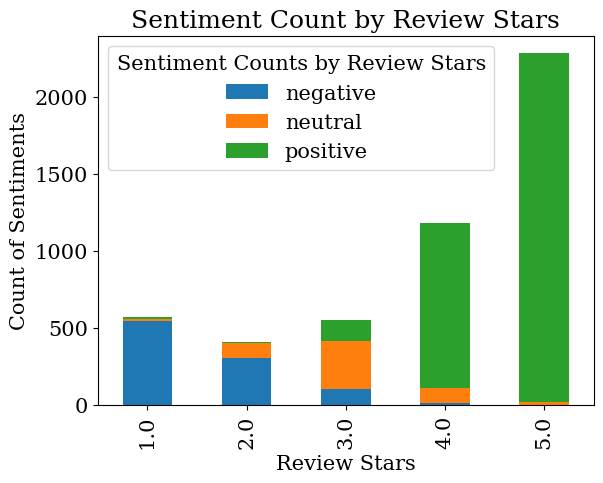

In [46]:
# Aggregate sentiments by review stars
sentiment_counts = test4.groupby(['review_stars', 'hf_sent_label']).size().reset_index(name='total_sentiment')

# Pivot the DataFrame for easier plotting
pivot_df = sentiment_counts.pivot(index='review_stars', columns='hf_sent_label', values='total_sentiment').fillna(0)

# Plotting
pivot_df.plot(kind='bar', stacked=True)
plt.title('Sentiment Count by Review Stars')
plt.xlabel('Review Stars')
plt.ylabel('Count of Sentiments')
plt.legend(title='Sentiment Counts by Review Stars')
plt.show()

This makes a lot of sense since most of the negative sentiment/blue color are in lower ratings and most of the positive sentiment/positive color are in higher ratings with neutral/orange concentrated in center of visualization: rating 3.

In [47]:
# Look at the box plot of sentiment ratios broken down by overall sentiment
# Plot boxplots for text_neg_ratio, text_neu_ratio, and text_pos_ratio broken down by hf_sent_label

# plt.figure(figsize=(15, 5))

# # Plot for text_neg_ratio
# plt.subplot(1, 3, 1)
# sns.boxplot(x='hf_sent_label', y='text_neg_ratio', data=test4)
# plt.title('Boxplot of text_neg_ratio by Sentiment Label')

# # Plot for text_neu_ratio
# plt.subplot(1, 3, 2)
# sns.boxplot(x='hf_sent_label', y='text_neu_ratio', data=test4)
# plt.title('Boxplot of text_neu_ratio by Sentiment Label')

# # Plot for text_pos_ratio
# plt.subplot(1, 3, 3)
# sns.boxplot(x='hf_sent_label', y='text_pos_ratio', data=test4)
# plt.title('Boxplot of text_pos_ratio by Sentiment Label')

# # Adjust layout and show plot
# plt.tight_layout()
# plt.show()

High negative and high positive ratios correspond with neg/pos sentiments. Review sentiment composition gets murky with neutral sentiment since a neutral stance with a restaurant can have a bunch of negative or neutral comments. Would need to look at star rating to get a better view of what sentiment is majority in neutral classified reviews. Let's take a quick peek.

In [48]:
# query = """
# select review_stars
# , clean_text
# , hf_sent_label
# -- , text_neu_ratio
# -- , text_neg_ratio
# -- , text_pos_ratio
# from test4
# where hf_sent_label = 'neutral'
# """

# neutral = duckdb.query(query).df()
# neutral.head(10)

Text mostly is comprised of what:

0. neutral then little neg; neutral ratio correct
1. neg; wrong neg ratio
2. pos and neg (60%); wrong ratio for pos
3. pos, neutral, neg; wrong ratio for pos
4. pos, neg; pos was second
5. neg, pos; neg was low percent
6. neg, pos; neg is lowest ratio
7. pos and neg; pos is higher than neg but neu highest
8. neg, pos; pos has higher ratio than neg but neu highest
9. pos, neg; pos then neg but neu ratio is highest

Mapping review stars to sentiment is difficult because people have varying subjectve definitions for what deserves a 1 versus 5.

In [49]:
# dfr.head()

In [50]:
# Join sample table to dfr to get category and date for review

query = """
select *
from test4
inner join (select review_id as review_id, categories, date from dfr) as dfr
on test4.review_id = dfr.review_id
"""

test5 = duckdb.query(query).df()
test5.head(10)

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,vader_rating,compound,neg,neu,pos,review_id_1,categories,date
0,Gh_J2fHgQE2mkRcTDYug7w,3.0,"a million years ago (ok, like 10), i had the shrimp and grits here, and it was one of those dishes i have dreamed about having when i traveled back to new orleans. i spent the last week telling my husband about it, and.....perhaps i should have left it all to memory. i literally got in from the airport, checked into my hotel, and booked it to desire. first off, the bar staff seemed annoyed that i was interrupting their chatter about the football game they were all watching behind the bar. eh, whatever. i can handle that, just give me the food. the grits were great. the rest.....eh. the shrimp were so tough i only ate half of them, and there were very few pieces of the tasso ham, which was what i remember loving from my first experience....overall, needed some salt, and some better service. luckily, i have time to try a few more places to find a new fav, and the locals have provided some great recommendations. i don't think i'll dream about this dish anymore :(",neutral,0.583760,"{'neg': 0.06, 'neu': 0.8, 'pos': 0.14, 'compound': 0.9522}",0.9522,0.060,0.800,0.140,Gh_J2fHgQE2mkRcTDYug7w,"Southern, Event Planning & Services, Restaurants, Cajun/Creole, Seafood, Live/Raw Food, Hotels & Travel, Hotels",2017-11-13 03:42:36
1,0yACuAEcKxf8pu5jrfJWcA,1.0,horrible service and it took 10min to get 2 glasses of tea. they need to step it up here!!,negative,0.990544,"{'neg': 0.194, 'neu': 0.806, 'pos': 0.0, 'compound': -0.6229}",-0.6229,0.194,0.806,0.000,0yACuAEcKxf8pu5jrfJWcA,"Food, Ice Cream & Frozen Yogurt, Burgers, Restaurants, Fast Food",2016-09-22 11:01:48
2,MhhVDS1Sv1Y-b2oXc4FTlw,5.0,legit perfectly hits the spot. crunchy pizza crust and bottom. not soggy at all. super friendly and nice service!!! just stopped by when i was hungry and i'm the area and i will definitely be back!,positive,0.994560,"{'neg': 0.04, 'neu': 0.585, 'pos': 0.375, 'compound': 0.9522}",0.9522,0.040,0.585,0.375,MhhVDS1Sv1Y-b2oXc4FTlw,"Restaurants, Pizza",2021-07-23 19:35:25
3,fqh7k_Zi0cdD8e8ydAU6eA,1.0,"i would like to give less. where to start... while waiting in line, a woman approached the counter with an incorrect order complaint that she got in the drive thru. this was followed by two separate dine in customers coming up with incorrect orders also. my daughter ordered a taco bell combo of loco tacos but cool ranch flavor, they came out wrong. the bathrooms were disgusting with no paper towels seating area was disgusting with food all over the place. at no time in the 25 minutes if we were there eating did anyone come out and wipe down any tables in the restaurant. i most likely will be getting food poisoning after that experience just from the fear of how my food was most likely handled. never again !!!",negative,0.990067,"{'neg': 0.203, 'neu': 0.767, 'pos': 0.031, 'compound': -0.9822}",-0.9822,0.203,0.767,0.031,fqh7k_Zi0cdD8e8ydAU6eA,"Restaurants, Fast Food, Chicken Wings, Chicken Shop",2016-11-06 18:03:37
4,qGB5IejZt3HqJmKJ_0Jatw,4.0,"really good sushi in the suburbs. this place is so close we can walk there but we'd drive because the food is so good! love the variety on the menu and everything we've tried has been amazing. don't let the location fool you, this is legit sushi!",positive,0.998183,"{'neg': 0.06, 'neu': 0.654, 'pos': 0.286, 'compound': 0.948}",0.9480,0.060,0.654,0.286,qGB5IejZt3HqJmKJ_0Jatw,"Japanese, Asian Fusion, Seafood, Restaurants, Sushi Bars",2019-08-08 19:28:40
5,PPTn2g7DHPvGXC7BuINs_Q,5.0,"there's a good reason why obama loves pi... it is beyond delicious. i get a warm fuzzy feeling just thinking about it. my first pi trip was after a particularly long and trying sunday at work. let me tell you, if you ever have a crappy day, just go have dinner at pi, it'll fix you right up. we're talking heaven here people. first off, order some wine. pi's selection of organic wines is awesome, an

In [51]:
# top categories mentioned in reviews
# test5['categories'].value_counts()

In [52]:
# Sentiment breakdown for category; only work with top 5
query = """
select *
from test5
where categories in ('Restaurants, Mexican', 'Restaurants, Pizza', 'Restaurants, Chinese', 'Restaurants, Italian', 'Restaurants, Seafood')
"""

test5 = duckdb.query(query).df()
test5.head(10)

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,vader_rating,compound,neg,neu,pos,review_id_1,categories,date
0,MhhVDS1Sv1Y-b2oXc4FTlw,5.0,legit perfectly hits the spot. crunchy pizza crust and bottom. not soggy at all. super friendly and nice service!!! just stopped by when i was hungry and i'm the area and i will definitely be back!,positive,0.994560,"{'neg': 0.04, 'neu': 0.585, 'pos': 0.375, 'compound': 0.9522}",0.9522,0.040,0.585,0.375,MhhVDS1Sv1Y-b2oXc4FTlw,"Restaurants, Pizza",2021-07-23 19:35:25
1,qr77kVINoKGqNUSmHN348Q,1.0,the worst over the phone customer service i've ever experienced in my 37yrs of life. manager stood by and allowed the cashier to get extremely nasty. the food was not prepared the way requested and i was told they can not remake the food nor offer any type of refund and i have to deal with it..canceled (.)!,negative,0.991058,"{'neg': 0.158, 'neu': 0.842, 'pos': 0.0, 'compound': -0.8736}",-0.8736,0.158,0.842,0.000,qr77kVINoKGqNUSmHN348Q,"Restaurants, Pizza",2020-04-04 03:32:41
2,z4aTnLnofycAb2xa-_5fgQ,5.0,had dinner here yesterday and it was incredible! the options are amazing and it was so much fun sitting at the bar watching the head chef make the orders. the ambiance is wonderful and i can't wait to bring all of my friends and family here and try some of the pizzas! i had the crema di broccoli with added pancetta and the confit garlic while my boyfriend had the gnocchi! i'll definitely be back,positive,0.997759,"{'neg': 0.0, 'neu': 0.793, 'pos': 0.207, 'compound': 0.9569}",0.9569,0.000,0.793,0.207,z4aTnLnofycAb2xa-_5fgQ,"Restaurants, Italian",2021-04-24 17:00:30
3,3KFRstETD8aMFSWEBWmGvw,4.0,"ok, so the tables and decor look a little dated and weird! however, we always have such a good time here. last night (saturday) they had karaoke and at first we were like ""oh no why did we come here"" but we had a blast! they placed all types of songs not just one genre. the beer is super super cheap....did i mention the beer is super super cheap? mike was our server and he was prompt, nice and we never had to go looking for him even though we decided not to sit in the main area. they are wheelchair accessible. there is long ramp on the side of the building in front of the accessible parking spots. the bathroom is also wheelchair accessible, nice and big with a sink in it. the bar seats are all high and no lowered seat for wheelchairs but there are plenty of tables. if you are in the brandon area, i would suggest you visit for a drink!",positive,0.954944,"{'neg': 0.039, 'neu': 0.775, 'pos': 0.186, 'compound': 0.9856}",0.9856,0.039,0.775,0.186,3KFRstETD8aMFSWEBWmGvw,"Restaurants, Seafood",2013-12-22 17:38:08
4,6or37ig6DfHe41HsAASb-g,3.0,"locals love this place. i honestly doubt you're reading this if you aren't a local. then again, if you are a local, you should already know about this place and have no need to read this. eh either way locals love this place. i say you've gotta try it for yourself. it's cheap and quick and they even have a drive through window. i didn't realize you could make pizza that fast, but who knows! i found it kinda runny, and cardboard like, but ok overall. now i just hope i don't get beat up for my three star review.",positive,0.528503,"{'neg': 0.032, 'neu': 0.8, 'pos': 0.168, 'compound': 0.933}",0.9330,0.032,0.800,0.168,6or37ig6DfHe41HsAASb-g,"Restaurants, Pizza",2007-07-21 06:13:19
5,BvH1lCQe7g5kSrY7aQQWoQ,1.0,"completely awful. i ordered a chef salad that per every online menu was a chef salad with ham, turkey, roast beef, provolone cheese, cucumbers etc. what i got was a salad with ham, onions, olives(???) and sweet peppers. i called and was told that i must have had an 'old menu' because their chef salad only had ham now. i called back after looking online and seeing every current menu was clearly what i had ordered. i was told that i was wrong. this is awful.",negative,0.989534,"{'neg': 0.119, 'neu': 0.815, 'pos': 0.066, 'compound': -0.6732}",-0.6732,0.119,0.815,0

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if

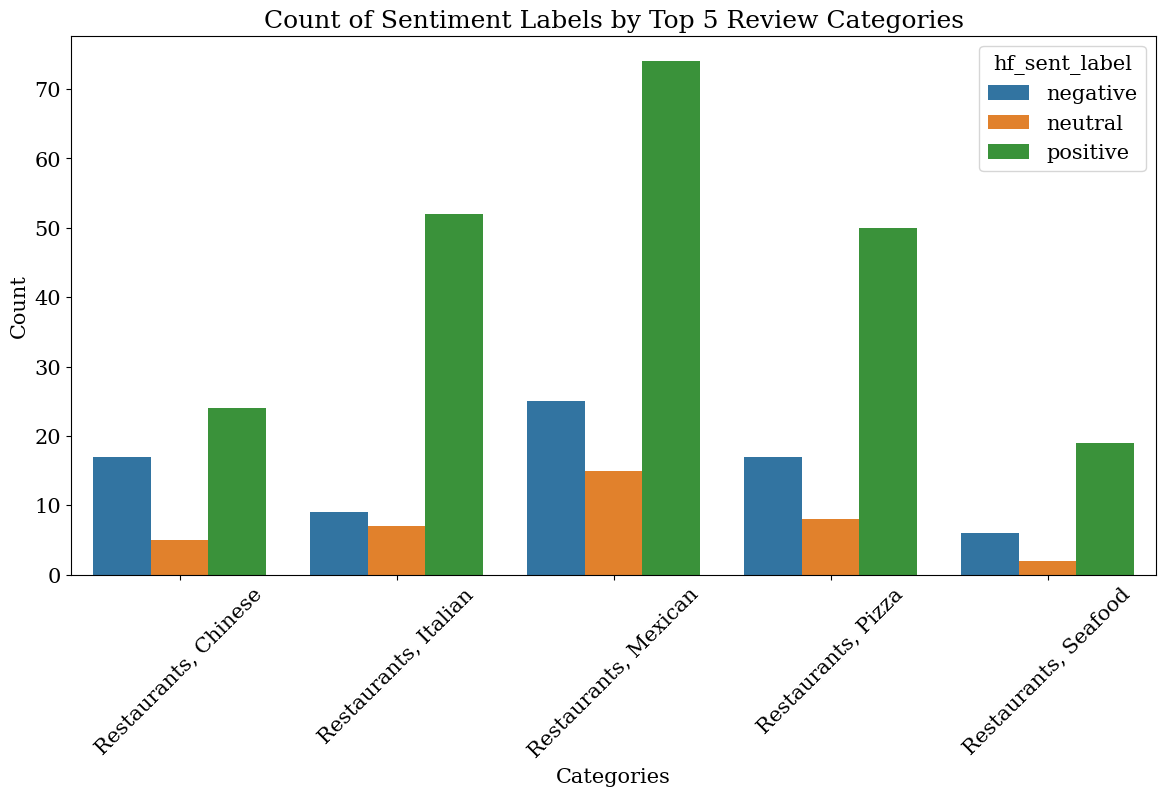

In [53]:
# Group by hf_sent_label and categories and count occurrences
df_grouped = test5.groupby(['hf_sent_label', 'categories']).size().reset_index(name='count')

# Plot the results
plt.figure(figsize=(14, 7))
sns.barplot(x='categories', y='count', hue='hf_sent_label', data=df_grouped)
plt.xticks(rotation=45)
plt.title('Count of Sentiment Labels by Top 5 Review Categories')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.show()

For Mexican Restaurants, positive reviews far outweigh any other cateory.

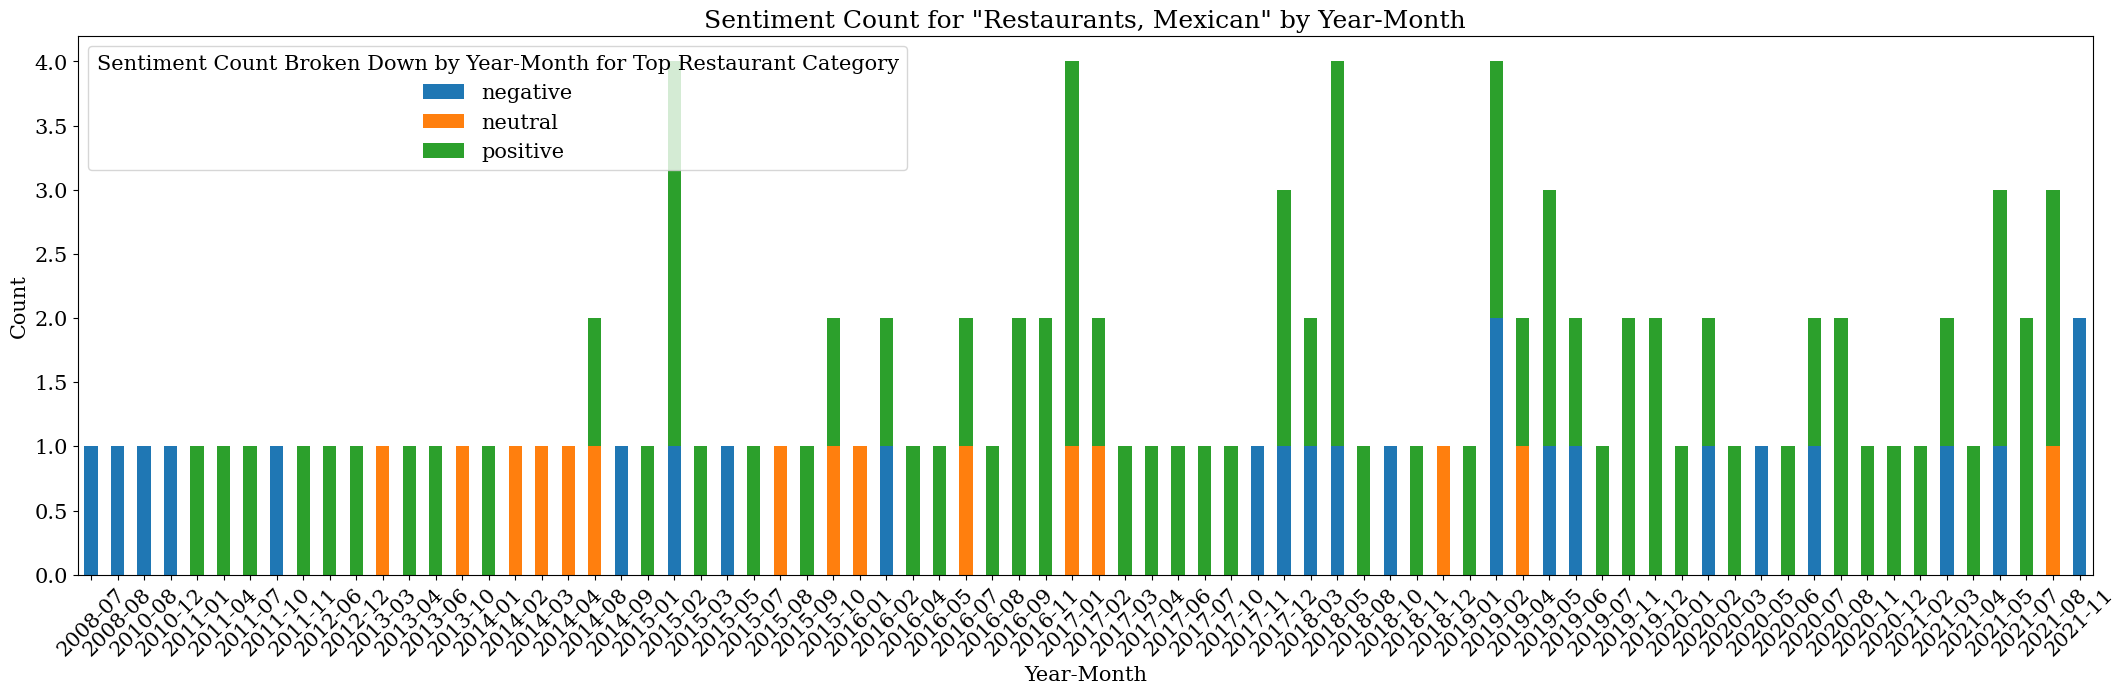

In [54]:
# Sentiment over time for top category: Restaurants, Mexican
# Filter the DataFrame to include only rows where categories is 'Restaurants, Mexican'
df_filtered = test5[test5['categories'] == 'Restaurants, Mexican']

# Convert the date column to datetime
df_filtered['date'] = pd.to_datetime(df_filtered['date'])

# Extract year and month from the date column
df_filtered['year_month'] = df_filtered['date'].dt.to_period('M')

# Group by hf_sent_label and year_month and count occurrences
df_grouped = df_filtered.groupby(['hf_sent_label', 'year_month']).size().reset_index(name='count')

# Pivot the data for plotting
df_pivot = df_grouped.pivot(index='year_month', columns='hf_sent_label', values='count').fillna(0)

# Plot the results
df_pivot.plot(kind='bar', stacked=True, figsize=(26, 7))
plt.title('Sentiment Count for "Restaurants, Mexican" by Year-Month')
plt.xlabel('Year-Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Sentiment Count Broken Down by Year-Month for Top Restaurant Category')
plt.show()

Mexican Restaurant category did best in 2018 spring. Would be interesting to focus in on one particular business and see sentiment trend over time.

And of course we want to know what are the reasons for certain sentiments. 
First, let's look at the most talked about topics in these restaurnt reviews.

# Topic Modeling


Extensive pre-processing need to be done because topic modeling cannot interpret all the text noise as well as Hugging Face LLM's can.

In [55]:
test6 = df_filtered.copy()

In [56]:
# Expand contractions and translate common social acronyms

# Dictionary for contractions
contractions_dict = {
    "i've": "I have",
    "can't": "cannot",
    "won't": "will not",
    "i'm": "I am",
    "you're": "you are",
    "you've": "you have",
    "they're": "they are",
    "we're": "we are",
    "it's": "it is",
    "he's": "he is",
    "she's": "she is",
    "that's": "that is",
    "there's": "there is",
    "isn't": "is not",
    "aren't": "are not",
    "wasn't": "was not",
    "weren't": "were not",
    "haven't": "have not",
    "hasn't": "has not",
    "hadn't": "had not",
    "wouldn't": "would not",
    "shouldn't": "should not",
    "couldn't": "could not",
    "doesn't": "does not",
    "don't": "do not",
    "didn't": "did not",
    "mustn't": "must not",
    "mightn't": "might not",
    "needn't": "need not",
    "you'd": "you would",
    "they'd": "they would",
    "we'd": "we would",
    "she'd": "she would",
    "he'd": "he would",
    "i'd": "I would",
    "it'd": "it would",
    "who'd": "who would",
    "what's": "what is",
    "how's": "how is",
    "let's": "let us",
    "here's": "here is"
}

# Dictionary for social acronyms
acronyms_dict = {
    "lol": "laugh out loud",
    "brb": "be right back",
    "gtg": "got to go",
    "idk": "I do not know",
    "imho": "in my humble opinion",
    "btw": "by the way",
    "omg": "oh my god",
    "ttyl": "talk to you later",
    "afaik": "as far as I know",
    "asap": "as soon as possible",
    "bff": "best friends forever",
    "fyi": "for your information",
    "lmk": "let me know",
    "nvm": "never mind",
    "smh": "shaking my head",
    "tbh": "to be honest",
    "wtf": "what the heck",
    "wth": "what the heck",
    "xoxo": "hugs and kisses"
}

# Combine both dictionaries
combined_dict = {**contractions_dict, **acronyms_dict}

# Function to expand contractions and acronyms
def expand_text(text):
    def replace(match):
        return combined_dict[match.group(0).lower()]

    pattern = re.compile(r'\b(' + '|'.join(re.escape(key) for key in combined_dict.keys()) + r')\b', re.IGNORECASE)
    expanded_text = pattern.sub(replace, text)
    return expanded_text

# Example usage
# text = "I've been busy lol. IDK what's happening, but can't wait to see you!"
# expanded_text = expand_text(text)
# print(expanded_text)

In [57]:
# given context of reviews, need to translate $ and % amounts into english

# def translate_amounts(text):
#     # Define regex patterns for dollar amounts and percentages
#     dollar_pattern = re.compile(r'\$(\d+(\.\d{1,2})?)')
#     percent_pattern = re.compile(r'(\d+(\.\d{1,2})?)%')

#     # Replace dollar amounts with "X dollars"
#     text = dollar_pattern.sub(lambda match: f"{float(match.group(1))} dollars", text)
    
#     # Replace percentages with "X percent"
#     text = percent_pattern.sub(lambda match: f"{float(match.group(1))} percent", text)
    
#     return text

# Example usage
# text = "The price is $4.00 and the discount is 4%."
# translated_text = translate_amounts(text)
# print(translated_text)  # Output: The price is 4.0 dollars and the discount is 4.0 percent.

In [58]:
# def replace_ampersand(text):
#     return text.replace('&', 'and')

# sentence = 'This is a test for &'
# print(replace_ampersand(sentence))

In [59]:
# def remove_punctuation(text):
#     return re.sub(r'[^\w\s]', '', text)

In [60]:
def more_txt_prep(text):
    # Define regex patterns for dollar amounts and percentages
    dollar_pattern = re.compile(r'\$(\d+(\.\d{1,2})?)')
    percent_pattern = re.compile(r'(\d+(\.\d{1,2})?)%')

    # Replace dollar amounts with "X dollars"
    text = dollar_pattern.sub(lambda match: f"{float(match.group(1))} dollars", text)
    
    # Replace percentages with "X percent"
    text = percent_pattern.sub(lambda match: f"{float(match.group(1))} percent", text)
    
    #replace ampersand
    text = text.replace('&', 'and')
    
    # remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    return text

In [61]:
# Some More Text Pre-Processing: tokenize, lemmatize, remove stop words

test6['clean_text2'] = test6.apply(lambda row: expand_text(row.clean_text), axis = 1)
test6['clean_text2'] = test6.apply(lambda row: more_txt_prep(row.clean_text2), axis = 1)
test6['tokenized'] = test6.apply(lambda row: tokenizer.tokenize(row.clean_text2), axis = 1)
test6.head()

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,vader_rating,compound,neg,neu,pos,review_id_1,categories,date,year_month,clean_text2,tokenized
6,dpRQqEtOgefuSdwWv2nLCA,5.0,this is my second time here and the food is good. love the warm chips and salsa. happy to have a mexican restaurant in the neighborhood.,positive,0.996122,"{'neg': 0.0, 'neu': 0.623, 'pos': 0.377, 'compound': 0.9136}",0.9136,0.000,0.623,0.377,dpRQqEtOgefuSdwWv2nLCA,"Restaurants, Mexican",2021-07-12 22:40:00,2021-07,this is my second time here and the food is good love the warm chips and salsa happy to have a mexican restaurant in the neighborhood,"[this, is, my, second, time, here, and, the, food, is, good, love, the, warm, chips, and, salsa, happy, to, have, a, mexican, restaurant, in, the, neighborhood]"
8,3rJqrzmT02RxDLWMhdm9gg,5.0,"had to stop into an alternate business across the road on a saturday morning (1 aug 2020) and had to hit a breakfast joint up - los betos was the spot! first thing that i want to recognize is the incredible timeline this place is open: mon-sat 0430-1000 pm!? then sunday from 0700-0600 pm. really going the distance here to make the availability to be open so for that, i'm quite impressed! second, the food is hot, fresh, delicious and fast! really gotta shout out that this food is delish. had a 'supreme' burrito and it was finger-licking darn delish!! drinks are not self serve through covid-19 at the moment but a large drink only costs you $2.00 seating is situated so you're about 6 feet apart as well. and, a popular mexican cable music channel is broadcasted on a little 32"" tv hanging on the wall. the store wasn't messy or smelly, but the look of it was a bit rough and weathered. half the lights didn't illuminate, can't discern if the surfaces where sanitized and the overall look was again, just rough. please don't look down too much on that but it is note worthy. personally, my family and i love dives per se; you can normally find some of the most humble restaurants and even better food. gripe time. not a fan of restaurants shutting down restrooms for 'covid'. there just isn't enough speaking power to present a convincing stance to me that this needs to be done. it restricts people under emergencies and with medical issues alongside with making the whole experience just better so you can wash your hands afterwards (or before for sanitation!) i'm not a fan of businesses that do this and they do here... overall, delicious food and grateful they're open and if you're in a hurry, the drive-through rocks too!!",positive,0.604875,"{'neg': 0.028, 'neu': 0.821, 'pos': 0.151, 'compound': 0.9918}",0.9918,0.028,0.821,0.151,3rJqrzmT02RxDLWMhdm9gg,"Restaurants, Mexican",2020-08-01 17:10:53,2020-08,had to stop into an alternate business across the road on a saturday morning 1 aug 2020 and had to hit a breakfast joint up los betos was the spot first thing that i want to recognize is the incredible timeline this place is open monsat 04301000 pm then sunday from 07000600 pm really going the distance here to make the availability to be open so for that I am quite impressed second the food is hot fresh delicious and fast really gotta shout out that this food is delish had a supreme burrito and it was fingerlicking darn delish drinks are not self serve through covid19 at the moment but a large drink only costs you 20 dollars seating is situated so you are about 6 feet apart as well and a popular mexican cable music channel is broadcasted on a little 32 tv hanging on the wall the store was not messy or smelly but the look of it was a bit rough and weathered half the lights did not illuminate cannot discern if the surfaces where sanitized and the overall look was again just rough please do not look down too much on that but it is note worthy personally my family and i love dives per se you can normally find some of the most humble restaurants and even better food gripe time not a fan of restaurants shutting down restrooms for covid 

In [62]:
# Function to remove stopwords from a list of tokens
def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    return [word for word in tokens if word.lower() not in stop_words]

# Remove stop words from the 'tokens' column
test6['tokens_no_stopwords'] = test6['tokenized'].apply(remove_stopwords)

test6.head()

/opt/conda/lib/python3.10/site-packages/nltk/corpus/reader/wordlist.py:28: ResourceWarning: unclosed file <_io.BufferedReader name='/usr/share/nltk_data/corpora/stopwords/english'>
  return concat([self.open(f).read() for f in fileids])


,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,vader_rating,compound,neg,neu,pos,review_id_1,categories,date,year_month,clean_text2,tokenized,tokens_no_stopwords
6,dpRQqEtOgefuSdwWv2nLCA,5.0,this is my second time here and the food is good. love the warm chips and salsa. happy to have a mexican restaurant in the neighborhood.,positive,0.996122,"{'neg': 0.0, 'neu': 0.623, 'pos': 0.377, 'compound': 0.9136}",0.9136,0.000,0.623,0.377,dpRQqEtOgefuSdwWv2nLCA,"Restaurants, Mexican",2021-07-12 22:40:00,2021-07,this is my second time here and the food is good love the warm chips and salsa happy to have a mexican restaurant in the neighborhood,"[this, is, my, second, time, here, and, the, food, is, good, love, the, warm, chips, and, salsa, happy, to, have, a, mexican, restaurant, in, the, neighborhood]","[second, time, food, good, love, warm, chips, salsa, happy, mexican, restaurant, neighborhood]"
8,3rJqrzmT02RxDLWMhdm9gg,5.0,"had to stop into an alternate business across the road on a saturday morning (1 aug 2020) and had to hit a breakfast joint up - los betos was the spot! first thing that i want to recognize is the incredible timeline this place is open: mon-sat 0430-1000 pm!? then sunday from 0700-0600 pm. really going the distance here to make the availability to be open so for that, i'm quite impressed! second, the food is hot, fresh, delicious and fast! really gotta shout out that this food is delish. had a 'supreme' burrito and it was finger-licking darn delish!! drinks are not self serve through covid-19 at the moment but a large drink only costs you $2.00 seating is situated so you're about 6 feet apart as well. and, a popular mexican cable music channel is broadcasted on a little 32"" tv hanging on the wall. the store wasn't messy or smelly, but the look of it was a bit rough and weathered. half the lights didn't illuminate, can't discern if the surfaces where sanitized and the overall look was again, just rough. please don't look down too much on that but it is note worthy. personally, my family and i love dives per se; you can normally find some of the most humble restaurants and even better food. gripe time. not a fan of restaurants shutting down restrooms for 'covid'. there just isn't enough speaking power to present a convincing stance to me that this needs to be done. it restricts people under emergencies and with medical issues alongside with making the whole experience just better so you can wash your hands afterwards (or before for sanitation!) i'm not a fan of businesses that do this and they do here... overall, delicious food and grateful they're open and if you're in a hurry, the drive-through rocks too!!",positive,0.604875,"{'neg': 0.028, 'neu': 0.821, 'pos': 0.151, 'compound': 0.9918}",0.9918,0.028,0.821,0.151,3rJqrzmT02RxDLWMhdm9gg,"Restaurants, Mexican",2020-08-01 17:10:53,2020-08,had to stop into an alternate business across the road on a saturday morning 1 aug 2020 and had to hit a breakfast joint up los betos was the spot first thing that i want to recognize is the incredible timeline this place is open monsat 04301000 pm then sunday from 07000600 pm really going the distance here to make the availability to be open so for that I am quite impressed second the food is hot fresh delicious and fast really gotta shout out that this food is delish had a supreme burrito and it was fingerlicking darn delish drinks are not self serve through covid19 at the moment but a large drink only costs you 20 dollars seating is situated so you are about 6 feet apart as well and a popular mexican cable music channel is broadcasted on a little 32 tv hanging on the wall the store was not messy or smelly but the look of it was a bit rough and weathered half the lights did not illuminate cannot discern if the surfaces where sanitized and the overall look was again just rough please do not look down too much on that but it is note worthy personally my family and i love dives per se you can normally find some of th

In [63]:
# Function to lemmatize a list of tokens
def lemmatize_tokens(tokens):
    doc = nlp(" ".join(tokens))
    return [token.lemma_ for token in doc]

# Apply the lemmatization function to the 'tokens' column
test6['lemmatized_tokens'] = test6['tokens_no_stopwords'].apply(lemmatize_tokens)

# Display the DataFrame
test6.head()

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,vader_rating,compound,neg,neu,pos,review_id_1,categories,date,year_month,clean_text2,tokenized,tokens_no_stopwords,lemmatized_tokens
6,dpRQqEtOgefuSdwWv2nLCA,5.0,this is my second time here and the food is good. love the warm chips and salsa. happy to have a mexican restaurant in the neighborhood.,positive,0.996122,"{'neg': 0.0, 'neu': 0.623, 'pos': 0.377, 'compound': 0.9136}",0.9136,0.000,0.623,0.377,dpRQqEtOgefuSdwWv2nLCA,"Restaurants, Mexican",2021-07-12 22:40:00,2021-07,this is my second time here and the food is good love the warm chips and salsa happy to have a mexican restaurant in the neighborhood,"[this, is, my, second, time, here, and, the, food, is, good, love, the, warm, chips, and, salsa, happy, to, have, a, mexican, restaurant, in, the, neighborhood]","[second, time, food, good, love, warm, chips, salsa, happy, mexican, restaurant, neighborhood]","[second, time, food, good, love, warm, chip, salsa, happy, mexican, restaurant, neighborhood]"
8,3rJqrzmT02RxDLWMhdm9gg,5.0,"had to stop into an alternate business across the road on a saturday morning (1 aug 2020) and had to hit a breakfast joint up - los betos was the spot! first thing that i want to recognize is the incredible timeline this place is open: mon-sat 0430-1000 pm!? then sunday from 0700-0600 pm. really going the distance here to make the availability to be open so for that, i'm quite impressed! second, the food is hot, fresh, delicious and fast! really gotta shout out that this food is delish. had a 'supreme' burrito and it was finger-licking darn delish!! drinks are not self serve through covid-19 at the moment but a large drink only costs you $2.00 seating is situated so you're about 6 feet apart as well. and, a popular mexican cable music channel is broadcasted on a little 32"" tv hanging on the wall. the store wasn't messy or smelly, but the look of it was a bit rough and weathered. half the lights didn't illuminate, can't discern if the surfaces where sanitized and the overall look was again, just rough. please don't look down too much on that but it is note worthy. personally, my family and i love dives per se; you can normally find some of the most humble restaurants and even better food. gripe time. not a fan of restaurants shutting down restrooms for 'covid'. there just isn't enough speaking power to present a convincing stance to me that this needs to be done. it restricts people under emergencies and with medical issues alongside with making the whole experience just better so you can wash your hands afterwards (or before for sanitation!) i'm not a fan of businesses that do this and they do here... overall, delicious food and grateful they're open and if you're in a hurry, the drive-through rocks too!!",positive,0.604875,"{'neg': 0.028, 'neu': 0.821, 'pos': 0.151, 'compound': 0.9918}",0.9918,0.028,0.821,0.151,3rJqrzmT02RxDLWMhdm9gg,"Restaurants, Mexican",2020-08-01 17:10:53,2020-08,had to stop into an alternate business across the road on a saturday morning 1 aug 2020 and had to hit a breakfast joint up los betos was the spot first thing that i want to recognize is the incredible timeline this place is open monsat 04301000 pm then sunday from 07000600 pm really going the distance here to make the availability to be open so for that I am quite impressed second the food is hot fresh delicious and fast really gotta shout out that this food is delish had a supreme burrito and it was fingerlicking darn delish drinks are not self serve through covid19 at the moment but a large drink only costs you 20 dollars seating is situated so you are about 6 feet apart as well and a popular mexican cable music channel is broadcasted on a little 32 tv hanging on the wall the store was not messy or smelly but the look of it was a bit rough and weathered half the lights did not illuminate cannot discern if the surfaces where sanitized and the overall look was again just rough please do not look down to

In [64]:
# turn cleaned up text column back to strings only

# Function to join list of strings into a single string
def list_to_string(list_of_strings):
    text = ' '.join(list_of_strings)
    return re.sub(r'[^\w\s]', '', text)  # remove punctuation again...

    
test6['clean_text3'] = test6['lemmatized_tokens'].apply(list_to_string)

# Display the DataFrame
test6.head()

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,vader_rating,compound,neg,neu,pos,review_id_1,categories,date,year_month,clean_text2,tokenized,tokens_no_stopwords,lemmatized_tokens,clean_text3
6,dpRQqEtOgefuSdwWv2nLCA,5.0,this is my second time here and the food is good. love the warm chips and salsa. happy to have a mexican restaurant in the neighborhood.,positive,0.996122,"{'neg': 0.0, 'neu': 0.623, 'pos': 0.377, 'compound': 0.9136}",0.9136,0.000,0.623,0.377,dpRQqEtOgefuSdwWv2nLCA,"Restaurants, Mexican",2021-07-12 22:40:00,2021-07,this is my second time here and the food is good love the warm chips and salsa happy to have a mexican restaurant in the neighborhood,"[this, is, my, second, time, here, and, the, food, is, good, love, the, warm, chips, and, salsa, happy, to, have, a, mexican, restaurant, in, the, neighborhood]","[second, time, food, good, love, warm, chips, salsa, happy, mexican, restaurant, neighborhood]","[second, time, food, good, love, warm, chip, salsa, happy, mexican, restaurant, neighborhood]",second time food good love warm chip salsa happy mexican restaurant neighborhood
8,3rJqrzmT02RxDLWMhdm9gg,5.0,"had to stop into an alternate business across the road on a saturday morning (1 aug 2020) and had to hit a breakfast joint up - los betos was the spot! first thing that i want to recognize is the incredible timeline this place is open: mon-sat 0430-1000 pm!? then sunday from 0700-0600 pm. really going the distance here to make the availability to be open so for that, i'm quite impressed! second, the food is hot, fresh, delicious and fast! really gotta shout out that this food is delish. had a 'supreme' burrito and it was finger-licking darn delish!! drinks are not self serve through covid-19 at the moment but a large drink only costs you $2.00 seating is situated so you're about 6 feet apart as well. and, a popular mexican cable music channel is broadcasted on a little 32"" tv hanging on the wall. the store wasn't messy or smelly, but the look of it was a bit rough and weathered. half the lights didn't illuminate, can't discern if the surfaces where sanitized and the overall look was again, just rough. please don't look down too much on that but it is note worthy. personally, my family and i love dives per se; you can normally find some of the most humble restaurants and even better food. gripe time. not a fan of restaurants shutting down restrooms for 'covid'. there just isn't enough speaking power to present a convincing stance to me that this needs to be done. it restricts people under emergencies and with medical issues alongside with making the whole experience just better so you can wash your hands afterwards (or before for sanitation!) i'm not a fan of businesses that do this and they do here... overall, delicious food and grateful they're open and if you're in a hurry, the drive-through rocks too!!",positive,0.604875,"{'neg': 0.028, 'neu': 0.821, 'pos': 0.151, 'compound': 0.9918}",0.9918,0.028,0.821,0.151,3rJqrzmT02RxDLWMhdm9gg,"Restaurants, Mexican",2020-08-01 17:10:53,2020-08,had to stop into an alternate business across the road on a saturday morning 1 aug 2020 and had to hit a breakfast joint up los betos was the spot first thing that i want to recognize is the incredible timeline this place is open monsat 04301000 pm then sunday from 07000600 pm really going the distance here to make the availability to be open so for that I am quite impressed second the food is hot fresh delicious and fast really gotta shout out that this food is delish had a supreme burrito and it was fingerlicking darn delish drinks are not self serve through covid19 at the moment but a large drink only costs you 20 dollars seating is situated so you are about 6 feet apart as well and a popular mexican cable music channel is broadcasted on a little 32 tv hanging on the wall the store was not messy or smelly but the look of it was a bit rough and weathered half the lights did not illuminate cannot discern if the 

In [65]:
# Now trying topic modeling with cleaned text!
reindexed_data = test6['clean_text3']
tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords.words('english') + ['food', 'ta', 'take'], use_idf=True, smooth_idf=True)
reindexed_data = reindexed_data.values
document_term_matrix = tfidf_vectorizer.fit_transform(reindexed_data)

/opt/conda/lib/python3.10/site-packages/nltk/corpus/reader/wordlist.py:28: ResourceWarning: unclosed file <_io.BufferedReader name='/usr/share/nltk_data/corpora/stopwords/english'>
  return concat([self.open(f).read() for f in fileids])


In [66]:
n_topics = 6
lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(document_term_matrix)

In [67]:
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [68]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

In [69]:
def get_top_n_words(n, keys, document_term_matrix, tfidf_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = tfidf_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

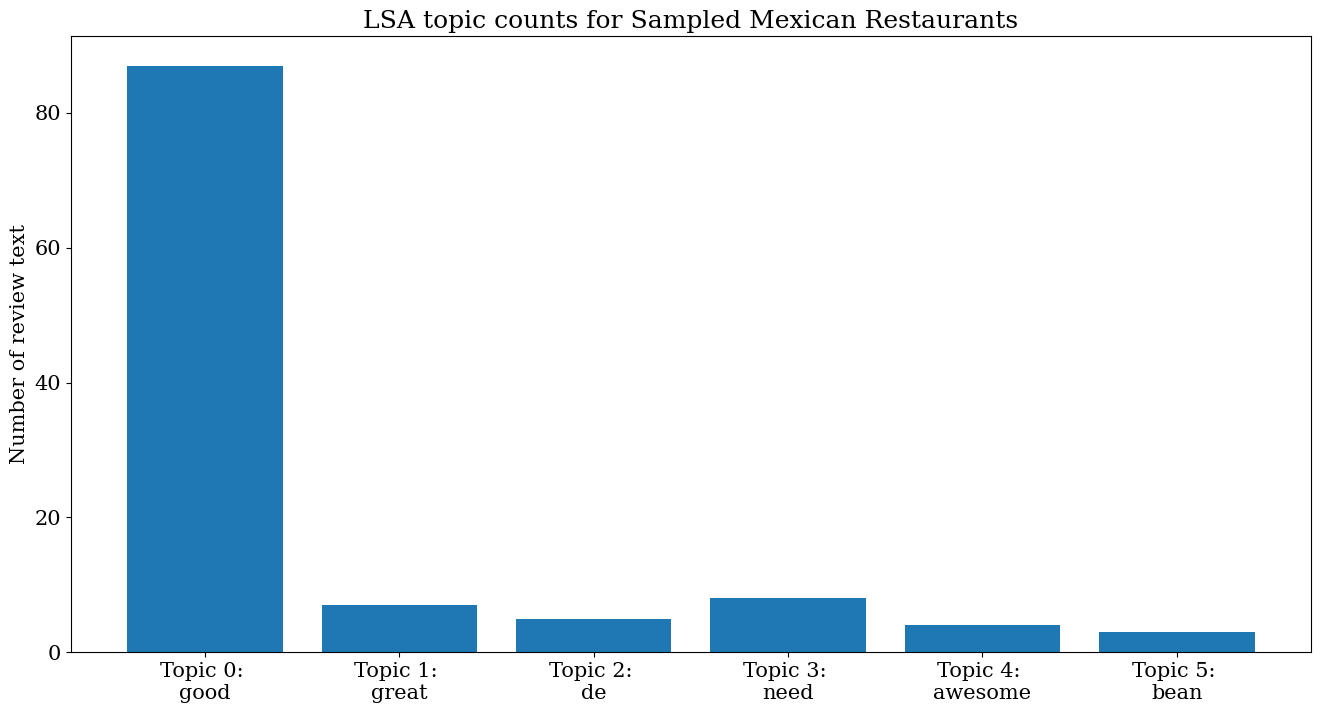

In [70]:
top_3_words = get_top_n_words(1, lsa_keys, document_term_matrix, tfidf_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lsa_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lsa_categories, lsa_counts);
ax.set_xticks(lsa_categories);
ax.set_xticklabels(labels);
ax.set_ylabel('Number of review text');
ax.set_title('LSA topic counts for Sampled Mexican Restaurants');
plt.show();

Not very good interpretation/extraction since Parts of Speech desired should be specified before doing topic modeling and text pre-processing made burrito burr...Trying another method.

In [71]:
# Testing out Algo

# Download NLTK stopwords
# nltk.download('stopwords')

# # Sample Yelp reviews DataFrame
# data = {
#     'review': [
#         "I love the tacos at this place. They're amazing!",
#         "The service was terrible, I will not come back.",
#         "Great atmosphere and friendly staff.",
#         "The food was cold and tasteless.",
#         "I enjoyed my time here, the music was good."
#     ]
# }
# df = pd.DataFrame(data)

# # Preprocess the reviews
# stop_words = set(stopwords.words('english'))
# df['processed'] = df['review'].apply(lambda x: [word for word in x.lower().split() if word not in stop_words])

# # Create a dictionary and corpus
# dictionary = corpora.Dictionary(df['processed'])
# corpus = [dictionary.doc2bow(text) for text in df['processed']]

# # Train the LDA model
# lda_model = LdaModel(corpus, num_topics=3, id2word=dictionary, passes=10)

# # Print the topics
# topics = lda_model.print_topics(num_words=5)
# for topic in topics:
#     print(topic)

1. Each line represets a different topic.
1. Topic can be inferred by given words, 5 total in this case.
1. Numbers next to words are probability that word would be chosen as topic in newly generated text.
1. These topics also cover adjectives. Need to do entity extraction to zoom-in on core review topics. For example, desired output would have been: food, service, ambiance.

Let's see what ouput is from applying this LDA model to Mexican restaurant reviews. 

In [72]:
stop_words = set(stopwords.words('english'))

test6['processed'] =test6['clean_text2'].apply(lambda x: [word for word in x.lower().split() if word not in stop_words])

# Create a dictionary and corpus
dictionary = corpora.Dictionary(test6['processed'])
corpus = [dictionary.doc2bow(text) for text in test6['processed']]

# Train the LDA model
lda_model = LdaModel(corpus, num_topics=3, id2word=dictionary, passes=10)

# Print the topics
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)

/opt/conda/lib/python3.10/site-packages/nltk/corpus/reader/wordlist.py:28: ResourceWarning: unclosed file <_io.BufferedReader name='/usr/share/nltk_data/corpora/stopwords/english'>
  return concat([self.open(f).read() for f in fileids])


(0, '0.017*"food" + 0.009*"place" + 0.009*"good" + 0.007*"mexican" + 0.006*"time"')
(1, '0.017*"food" + 0.013*"tacos" + 0.012*"place" + 0.008*"good" + 0.008*"mexican"')
(2, '0.021*"food" + 0.012*"good" + 0.011*"great" + 0.009*"place" + 0.009*"service"')


Once again, best to get parts of speech/aspects from text and then model the topics. Ideally, would want an ouput that mentions food, service and atmosphere topics with adjetives describing each.

In [73]:
# list of tuples with each tuple having unique word in text and its freq

# # Function to clean and tokenize text
# def tokenize(text):
#     # Convert text to lower case
#     text = text.lower()
#     # Remove punctuation and split by whitespace
#     words = re.findall(r'\b\w+\b', text)
#     return words

# # Apply the tokenize function to the text column and create a Counter
# word_counter = Counter()
# test6['clean_text2'].apply(lambda x: word_counter.update(tokenize(x)))

# # Convert the Counter to a list of tuples (word, frequency)
# word_freq = list(word_counter.items())

# # Display the result
# print(word_freq)

References:
* [Topic Modeling for Beginners Using BerTopic and Python](https://erickleppen.medium.com/topic-modeling-for-beginners-using-bertopic-and-python-aaf1b421afeb)

Trying out BERTopic model. Will try other methods to get different visualizations of topics.

In [74]:
# Trying BERTopic

docs = test6['clean_text2']

# Step 1 - Extract embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Step 2 - Reduce dimensionality
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine')

# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

# Step 4 - Tokenize topics
vectorizer_model = CountVectorizer(stop_words="english")

# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer()

# All steps together

representation_model = MaximalMarginalRelevance(diversity=0.5)
topic_model = BERTopic(
  embedding_model=embedding_model,    # Step 1 - Extract embeddings
  umap_model=umap_model,              # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,        # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,  # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,          # Step 5 - Extract topic words # Diversify topic words
  calculate_probabilities=True,        
  verbose=True,
  representation_model=representation_model
)

topics, probs = topic_model.fit_transform(docs)
topic_model.get_topic_info()

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2024-06-18 00:50:58,198 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

2024-06-18 00:51:03,594 - BERTopic - Embedding - Completed ✓
2024-06-18 00:51:03,595 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-06-18 00:51:16,549 - BERTopic - Dimensionality - Completed ✓
2024-06-18 00:51:16,550 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-06-18 00:51:16,602 - BERTopic - Cluster - Completed ✓
2024-06-18 00:51:16,609 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-06-18 00:51:17,088 - BERTopic - Representation - Completed ✓


,Topic,Count,Name,Representation,Representative_Docs
0,-1,60,-1_tacos_salsa_friendly_chicken,"[tacos, salsa, friendly, chicken, ordered, el, experience, mexican, restaurant, guacamole]","[the 25 stars made me a little concerned about coming here but my wife and i were mexicans in another lifetime we were hungry and codys was packed with a half hour wait we were far from our home base so i whipped out my trusty yelp app it told me this place was just down the road but the reviews were not encouraging but we came anyway we ordered the house guacamole and a side of refried beans like we usually do in mexican restaurants to accompany the chips and salsa the house guac was awesome check out my picture it was more an avocado salad than guacamole the avocado was cut in pieces not smashed and i loved every bite the refried beans were tasty we ordered them without cheese because that is how we roll we were feeling adventurous and there was an ad for la parrillada on the bottom of the menu it is like fajitas on steroids with steak chicken shrimp and chorizo it was outstanding all the meats were mixed together and the chorizo gave this plate a very zesty kick you gotta try it service was good my diet coke was always filled food came out fast and with good presentation i cannot speak to what the other reviewers experienced and this is just my experience this one time all i can say is that i enjoyed the experience the food was good and even though this is out of my way I am coming back i cannot pay a restaurant a higher compliment ymmv, the only reason they are getting 3 stars is for the happy hour which is fantastic and their patio which is a great place to be in the summer time I would highly recommend them for happy hour theyve got tvs behind the bar a large drink selection and delicious appetizers for dinner i honestly cannot understand the pricing for mexican food they are extremely over priced granted the food is good but 200 dollars for chicken enchiladas come on again it is good and if you do not know better you might think it is worth it but it is definitely not I have had better food for half the price i think part of the justification on their part is the ingredients that they use to me not noticeable enough difference to charge a premium i ate with a large party and the service was pretty good they were attentive the chef came out to ask us how everything was and we were able to split our check among 5 couples at our table with no issue which is greatly appreciated if for some reason you want fancy mexican food check it out otherwise you are probably better served looking elsewhere and saving some money, met friends for dinner though the food was excellent and the portions were large the service was sub par having never been there we did not know we had to order at counter and sat there waiting and waiting we were the only customers in the establishment for dinner there were at least two employees behind the counter 10 feet away and never said anything or offered glasses for the wine we brought after waiting 20 minutes we went to the counter and asked if we could see menus and or order the person at the counter was on a cell phone the entire time we were there after looking at the menus and going back up to order the food was served quickly in paper trays other than bringing the food to the table there was absolutely no customer service the food was authentic and delicious but heavy portions were large and we all left full a little more expensive than expected especially having no table service paper take out trays for plates plastic utensils condiments salsa sour cream in plastic capped cups and only plastic cups for wine for a byob prices cheap if just getting main dish but adds up if get appetizers although food is pretty good you would not be missing any atmosphere or service if you were order and take out the food and enjoy it at home i understand a small business trying to save money with all plastic and paper but if felt

* The first topic is -1 and contains the most records. This is the outliers topic and should typically be ignored during analysis.
* Let's try another embedder.

In [75]:
%%time

#load the universal sentence encoder model
use4 = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

#generate embeddings
use4_embeddings = use4(test6['clean_text2'])
use= np.array(use4_embeddings)

#create list from np arrays to store the embeddings in the dataframe
test6['use4'] = use.tolist()

#pass the embeddings into BERTopic
topic_model.fit_transform(docs, use)

#get topic info
topic_model.get_topic_info()

2024-06-18 00:51:41,593 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-06-18 00:51:45,714 - BERTopic - Dimensionality - Completed ✓
2024-06-18 00:51:45,716 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-06-18 00:51:45,726 - BERTopic - Cluster - Completed ✓
2024-06-18 00:51:45,730 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-06-18 00:51:45,832 - BERTopic - Representation - Completed ✓


CPU times: user 19.9 s, sys: 4.9 s, total: 24.8 s
Wall time: 28.3 s


,Topic,Count,Name,Representation,Representative_Docs
0,-1,114,-1_tacos_mexican_salsa_delicious,"[tacos, mexican, salsa, delicious, restaurant, like, ordered, chips, el, awesome]","[the 25 stars made me a little concerned about coming here but my wife and i were mexicans in another lifetime we were hungry and codys was packed with a half hour wait we were far from our home base so i whipped out my trusty yelp app it told me this place was just down the road but the reviews were not encouraging but we came anyway we ordered the house guacamole and a side of refried beans like we usually do in mexican restaurants to accompany the chips and salsa the house guac was awesome check out my picture it was more an avocado salad than guacamole the avocado was cut in pieces not smashed and i loved every bite the refried beans were tasty we ordered them without cheese because that is how we roll we were feeling adventurous and there was an ad for la parrillada on the bottom of the menu it is like fajitas on steroids with steak chicken shrimp and chorizo it was outstanding all the meats were mixed together and the chorizo gave this plate a very zesty kick you gotta try it service was good my diet coke was always filled food came out fast and with good presentation i cannot speak to what the other reviewers experienced and this is just my experience this one time all i can say is that i enjoyed the experience the food was good and even though this is out of my way I am coming back i cannot pay a restaurant a higher compliment ymmv, met friends for dinner though the food was excellent and the portions were large the service was sub par having never been there we did not know we had to order at counter and sat there waiting and waiting we were the only customers in the establishment for dinner there were at least two employees behind the counter 10 feet away and never said anything or offered glasses for the wine we brought after waiting 20 minutes we went to the counter and asked if we could see menus and or order the person at the counter was on a cell phone the entire time we were there after looking at the menus and going back up to order the food was served quickly in paper trays other than bringing the food to the table there was absolutely no customer service the food was authentic and delicious but heavy portions were large and we all left full a little more expensive than expected especially having no table service paper take out trays for plates plastic utensils condiments salsa sour cream in plastic capped cups and only plastic cups for wine for a byob prices cheap if just getting main dish but adds up if get appetizers although food is pretty good you would not be missing any atmosphere or service if you were order and take out the food and enjoy it at home i understand a small business trying to save money with all plastic and paper but if felt more like a strictly take out place it was very clean worth a visit for the food just do not expect any atmosphere or warmth it felt like they could care less if we were there, the only reason they are getting 3 stars is for the happy hour which is fantastic and their patio which is a great place to be in the summer time I would highly recommend them for happy hour theyve got tvs behind the bar a large drink selection and delicious appetizers for dinner i honestly cannot understand the pricing for mexican food they are extremely over priced granted the food is good but 200 dollars for chicken enchiladas come on again it is good and if you do not know better you might think it is worth it but it is definitely not I have had better food for half the price i think part of the justification on their part is the ingredients that they use to me not noticeable enough difference to charge a premium i ate with a large party and the service was pretty good they were attentive the chef came out to ask us how everything was and we were able to split our check among 5 couples at our table with no issue 

These different embeddings create topics that make more sense because selected words per topic have a theme:  service, food

In [76]:
topic_model.get_topic(0)

False

### Trying Bigger dataset (with top 5 restaurants) to get more topics to avoid visualize_topics error

In [77]:
# %%time

# #load the universal sentence encoder model
# use4 = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

# #generate embeddings
# use4_embeddings = use4(test5['clean_text'])
# use= np.array(use4_embeddings)

# #create list from np arrays to store the embeddings in the dataframe
# test5['use4'] = use.tolist()

# #pass the embeddings into BERTopic
# topic_model.fit_transform(docs, use)

# #get topic info
# topic_model.get_topic_info()

In [78]:
# from hdbscan import HDBSCAN

# hdbscan_model = HDBSCAN(min_cluster_size=20, metric='euclidean', prediction_data=True)
# topic_model = BERTopic(hdbscan_model=hdbscan_model).fit(docs)

In [79]:
# Visualize topics
# topic_model.visualize_topics()

In [80]:
# topic_model.visualize_barchart()

In [81]:
# topic_model.visualize_heatmap()

# Aspect Extraction: What is being talked about at the review level? - Topics at a more granular level

In [82]:
# get relevant columns
test7 = test6[['review_id',
 'review_stars',
 'clean_text',
 'hf_sent_label',
 'hf_sent_score',
 'review_id_1',
 'categories',
 'clean_text2']]

In [83]:
test7.head()

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,review_id_1,categories,clean_text2
6,dpRQqEtOgefuSdwWv2nLCA,5.0,this is my second time here and the food is good. love the warm chips and salsa. happy to have a mexican restaurant in the neighborhood.,positive,0.996122,dpRQqEtOgefuSdwWv2nLCA,"Restaurants, Mexican",this is my second time here and the food is good love the warm chips and salsa happy to have a mexican restaurant in the neighborhood
8,3rJqrzmT02RxDLWMhdm9gg,5.0,"had to stop into an alternate business across the road on a saturday morning (1 aug 2020) and had to hit a breakfast joint up - los betos was the spot! first thing that i want to recognize is the incredible timeline this place is open: mon-sat 0430-1000 pm!? then sunday from 0700-0600 pm. really going the distance here to make the availability to be open so for that, i'm quite impressed! second, the food is hot, fresh, delicious and fast! really gotta shout out that this food is delish. had a 'supreme' burrito and it was finger-licking darn delish!! drinks are not self serve through covid-19 at the moment but a large drink only costs you $2.00 seating is situated so you're about 6 feet apart as well. and, a popular mexican cable music channel is broadcasted on a little 32"" tv hanging on the wall. the store wasn't messy or smelly, but the look of it was a bit rough and weathered. half the lights didn't illuminate, can't discern if the surfaces where sanitized and the overall look was again, just rough. please don't look down too much on that but it is note worthy. personally, my family and i love dives per se; you can normally find some of the most humble restaurants and even better food. gripe time. not a fan of restaurants shutting down restrooms for 'covid'. there just isn't enough speaking power to present a convincing stance to me that this needs to be done. it restricts people under emergencies and with medical issues alongside with making the whole experience just better so you can wash your hands afterwards (or before for sanitation!) i'm not a fan of businesses that do this and they do here... overall, delicious food and grateful they're open and if you're in a hurry, the drive-through rocks too!!",positive,0.604875,3rJqrzmT02RxDLWMhdm9gg,"Restaurants, Mexican",had to stop into an alternate business across the road on a saturday morning 1 aug 2020 and had to hit a breakfast joint up los betos was the spot first thing that i want to recognize is the incredible timeline this place is open monsat 04301000 pm then sunday from 07000600 pm really going the distance here to make the availability to be open so for that I am quite impressed second the food is hot fresh delicious and fast really gotta shout out that this food is delish had a supreme burrito and it was fingerlicking darn delish drinks are not self serve through covid19 at the moment but a large drink only costs you 20 dollars seating is situated so you are about 6 feet apart as well and a popular mexican cable music channel is broadcasted on a little 32 tv hanging on the wall the store was not messy or smelly but the look of it was a bit rough and weathered half the lights did not illuminate cannot discern if the surfaces where sanitized and the overall look was again just rough please do not look down too much on that but it is note worthy personally my family and i love dives per se you can normally find some of the most humble restaurants and even better food gripe time not a fan of restaurants shutting down restrooms for covid there just is not enough speaking power to present a convincing stance to me that this needs to be done it restricts people under emergencies and with medical issues alongside with making the whole experience just better so you can wash your hands afterwards or before for sanitation I am not a fan of businesses that do this and they do here overall delicious food and grateful they are open and if you are in a hurry the drivethrough rocks too
10,wVhmXDEA

# Aspect-based Sentiment Analysis/Opinion Mining
With aspect-based sentiment analysis, can get a better idea on what led to Vader's neg, neutral and pos ratios from each review.

In [84]:
# get small sample of reviews to test algo on
sample = test7.head(5)
sample

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,review_id_1,categories,clean_text2
6,dpRQqEtOgefuSdwWv2nLCA,5.0,this is my second time here and the food is good. love the warm chips and salsa. happy to have a mexican restaurant in the neighborhood.,positive,0.996122,dpRQqEtOgefuSdwWv2nLCA,"Restaurants, Mexican",this is my second time here and the food is good love the warm chips and salsa happy to have a mexican restaurant in the neighborhood
8,3rJqrzmT02RxDLWMhdm9gg,5.0,"had to stop into an alternate business across the road on a saturday morning (1 aug 2020) and had to hit a breakfast joint up - los betos was the spot! first thing that i want to recognize is the incredible timeline this place is open: mon-sat 0430-1000 pm!? then sunday from 0700-0600 pm. really going the distance here to make the availability to be open so for that, i'm quite impressed! second, the food is hot, fresh, delicious and fast! really gotta shout out that this food is delish. had a 'supreme' burrito and it was finger-licking darn delish!! drinks are not self serve through covid-19 at the moment but a large drink only costs you $2.00 seating is situated so you're about 6 feet apart as well. and, a popular mexican cable music channel is broadcasted on a little 32"" tv hanging on the wall. the store wasn't messy or smelly, but the look of it was a bit rough and weathered. half the lights didn't illuminate, can't discern if the surfaces where sanitized and the overall look was again, just rough. please don't look down too much on that but it is note worthy. personally, my family and i love dives per se; you can normally find some of the most humble restaurants and even better food. gripe time. not a fan of restaurants shutting down restrooms for 'covid'. there just isn't enough speaking power to present a convincing stance to me that this needs to be done. it restricts people under emergencies and with medical issues alongside with making the whole experience just better so you can wash your hands afterwards (or before for sanitation!) i'm not a fan of businesses that do this and they do here... overall, delicious food and grateful they're open and if you're in a hurry, the drive-through rocks too!!",positive,0.604875,3rJqrzmT02RxDLWMhdm9gg,"Restaurants, Mexican",had to stop into an alternate business across the road on a saturday morning 1 aug 2020 and had to hit a breakfast joint up los betos was the spot first thing that i want to recognize is the incredible timeline this place is open monsat 04301000 pm then sunday from 07000600 pm really going the distance here to make the availability to be open so for that I am quite impressed second the food is hot fresh delicious and fast really gotta shout out that this food is delish had a supreme burrito and it was fingerlicking darn delish drinks are not self serve through covid19 at the moment but a large drink only costs you 20 dollars seating is situated so you are about 6 feet apart as well and a popular mexican cable music channel is broadcasted on a little 32 tv hanging on the wall the store was not messy or smelly but the look of it was a bit rough and weathered half the lights did not illuminate cannot discern if the surfaces where sanitized and the overall look was again just rough please do not look down too much on that but it is note worthy personally my family and i love dives per se you can normally find some of the most humble restaurants and even better food gripe time not a fan of restaurants shutting down restrooms for covid there just is not enough speaking power to present a convincing stance to me that this needs to be done it restricts people under emergencies and with medical issues alongside with making the whole experience just better so you can wash your hands afterwards or before for sanitation I am not a fan of businesses that do this and they do here overall delicious food and grateful they are open and if you are in a hurry the drivethrough rocks too
10,wVhmXDEA

### Get Aspects from clean_text. Let us target food, the service, then ambiance

References:
1. [NLP: Gaining insights from text reviews](https://towardsdatascience.com/nlp-gaining-insights-from-text-reviews-94ef955c58c0)
1. [Adpect-Based Opinion Mining](https://medium.com/@pmin91/aspect-based-opinion-mining-nlp-with-python-a53eb4752800)

In [85]:
# Let us try HuggingFace model since MonkeyLearn had sign-up/API issues

model_name = "yangheng/deberta-v3-large-absa-v1.1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


tokenizer_config.json:   0%|          | 0.00/397 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/18.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:550: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

In [86]:
aspects = ["food", "service", "ambience"]

text = """
the service was absolutely horrible. 
the restaurant was not very busy, and yet we waited over 1 hour for our food. 
would not recommend if you are expecting good service. 
additionally, the food was very sub par. the draft beer was flat, 
and the other drinks were nothing special. 
would advise elsewhere for mexican food.
"""

for aspect in aspects:
   print(aspect, classifier(text,  text_pair=aspect))

food [{'label': 'Negative', 'score': 0.8268147110939026}]
service [{'label': 'Negative', 'score': 0.9997759461402893}]
ambience [{'label': 'Negative', 'score': 0.9601736664772034}]


Not sure about negative ambiance since this was not explicitly talked about in review. Let's try others.

In [87]:
aspects = ["food", "service", "ambiance"]

text = """
so we went to this restaurant last night as we were looking for more authentic mexican. 
we'd been there once before when they first opened. 
had to say, we were pretty blown away by how good it was--there were 5 of us, and everything was excellent--literally excellent. 
we had the shrimp ceviche, shrimp tacos, the chicken nachos, chicken burrito, chicken tacos and then the chorizos for dessert (warm, right out of the oven!). 
all were made with fresh ingredients, were of large portion sizes and best of all the seasonings and flavors were superb. 
they brought us a great pitcher of margarita mix (which was excellent as well) and went nicely with our sauza to make great margaritas in the large glasses they provide for them. 
i have to say this is a rare gem of a find, highly worth it, and we are already telling people to go there. total bill for 5 people was $125 too--a real bargain. 
plus the setting was very nice, sitting on the streets of haddonfield, well-shaded. staff/service was on point too--attentive and very prompt. great place.
"""

for aspect in aspects:
   print(aspect, classifier(text,  text_pair=aspect))

food [{'label': 'Positive', 'score': 0.997377872467041}]
service [{'label': 'Positive', 'score': 0.9996957778930664}]
ambiance [{'label': 'Positive', 'score': 0.9966110587120056}]


This time around, ambiance was mentioned as "setting" and positive sentiment detected.

In [88]:
aspects = ["food", "service", "ambiance"]

text = """
amazing food!!! 
looks like a hole in the wall kind of place but those are always the hidden gems. 
the stuff the tacos, so i was full off of three! 
they were quick and efficient. 
loved it!
"""

for aspect in aspects:
   print(aspect, classifier(text,  text_pair=aspect))

food [{'label': 'Positive', 'score': 0.9999120235443115}]
service [{'label': 'Positive', 'score': 0.9970831274986267}]
ambiance [{'label': 'Positive', 'score': 0.9277939200401306}]


## Really cool how predictive model was able to determine aspects in review and determine sentiment. 
### Next step is determine what caused aspect sentiment specifically from review. For example, tacos were food aspect that led to positive sentiment for food.

In [89]:
# Maybe get key aspects first that fit under food, service and ambiance. Then get descriptors. And from their classify review with sentiment.

# Trying PyABSA again

In [90]:
# from pyabsa import available_checkpoints
# checkpoint_map = available_checkpoints(from_local=False)

In [91]:
aspect_extractor = ATEPCCheckpointManager.get_aspect_extractor(checkpoint='english',
                                   auto_device=True  # False means load model on CPU
                                   )

[2024-06-18 01:02:22] (2.4.1.post1) ********** Available ATEPC model checkpoints for Version:2.4.1.post1 (this version) **********
[2024-06-18 01:02:22] (2.4.1.post1) ********** Available ATEPC model checkpoints for Version:2.4.1.post1 (this version) **********
[2024-06-18 01:02:22] (2.4.1.post1) Downloading checkpoint:english 
[2024-06-18 01:02:22] (2.4.1.post1) Notice: The pretrained model are used for testing, it is recommended to train the model on your own custom datasets


Find zipped checkpoint: ./checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43.zip, unzipping


Done.
[2024-06-18 01:02:32] (2.4.1.post1) If the auto-downloading failed, please download it via browser: https://huggingface.co/spaces/yangheng/PyABSA/resolve/main/checkpoints/English/ATEPC/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43.zip 
[2024-06-18 01:02:32] (2.4.1.post1) Load aspect extractor from checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43
[2024-06-18 01:02:32] (2.4.1.post1) config: checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43/fast_lcf_atepc.config
[2024-06-18 01:02:32] (2.4.1.post1) state_dict: checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43/fast_lcf_atepc.state_dict
[2024-06-18 01:02:32] (2.4.1.post1) model: None
[2024-06-18 01:02:32] (2.4.1.post1) tokenizer: checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43/fast_lcf_atepc.tokenizer
[2024-06-18 0

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

In [92]:
# You can inference from a list of setences or a DatasetItem from PyABSA 
examples = ['Staff was very rude but food was delicious']
inference_source = examples
atepc_result = aspect_extractor.extract_aspect(inference_source=inference_source,  #
                          pred_sentiment=True,  # Predict the sentiment of extracted aspect terms
                          )

/opt/conda/lib/python3.10/site-packages/pyabsa/tasks/AspectTermExtraction/prediction/aspect_extractor.py:593: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  lcf_cdm_vec = torch.tensor(


[2024-06-18 01:02:43] (2.4.1.post1) The results of aspect term extraction have been saved in /kaggle/working/Aspect Term Extraction and Polarity Classification.FAST_LCF_ATEPC.result.json
[2024-06-18 01:02:43] (2.4.1.post1) Example 0: Staff was very rude but <food:Positive Confidence:0.9994> was delicious


In [93]:
atepc_result

[{'sentence': 'Staff was very rude but food was delicious',
  'IOB': ['B-ASP', 'O', 'O', 'O', 'O', 'B-ASP', 'O', 'O'],
  'tokens': ['Staff',
   'was',
   'very',
   'rude',
   'but',
   'food',
   'was',
   'delicious'],
  'aspect': ['Staff', 'food'],
  'position': [[0], [5]],
  'sentiment': ['Negative', 'Positive'],
  'probs': [[0.9969356060028076, 0.0028198729269206524, 0.0002444849524181336],
   [0.0003258804208599031, 0.0002935871889349073, 0.9993804693222046]],
  'confidence': [0.9969, 0.9994]}]

In [94]:
# Now let us try out couple of the yelp reviews
examples = ['''so we went to this restaurant last night as we were looking for more authentic mexican. 
we'd been there once before when they first opened. 
had to say, we were pretty blown away by how good it was--there were 5 of us, and everything was excellent--literally excellent. 
we had the shrimp ceviche, shrimp tacos, the chicken nachos, chicken burrito, chicken tacos and then the chorizos for dessert (warm, right out of the oven!). 
all were made with fresh ingredients, were of large portion sizes and best of all the seasonings and flavors were superb. 
they brought us a great pitcher of margarita mix (which was excellent as well) and went nicely with our sauza to make great margaritas in the large glasses they provide for them. 
i have to say this is a rare gem of a find, highly worth it, and we are already telling people to go there. total bill for 5 people was $125 too--a real bargain. 
plus the setting was very nice, sitting on the streets of haddonfield, well-shaded. staff/service was on point too--attentive and very prompt. great place.''']

atepc_result2 = aspect_extractor.extract_aspect(inference_source=examples,  #
                          pred_sentiment=True,  # Predict the sentiment of extracted aspect terms
                          )

[2024-06-18 01:02:53] (2.4.1.post1) The results of aspect term extraction have been saved in /kaggle/working/Aspect Term Extraction and Polarity Classification.FAST_LCF_ATEPC.result.json
[2024-06-18 01:02:53] (2.4.1.post1) Example 0: so we went to this restaurant last night as we were looking for more authentic mexican . we ' d been there once before when they first opened . had to say , we were pretty blown away by how good <it:Positive Confidence:0.9987> was - - there were 5 of us , and everything was excellent - - literally excellent . we had the shrimp <ceviche:Positive Confidence:0.9959> , shrimp tacos , the chicken nachos , chicken burrito , chicken tacos and then the chorizos for dessert ( warm , right out of the oven ! ) . all were made with fresh ingredients , were of large <portion:Positive Confidence:0.9991> sizes and best of all the seasonings and <flavors:Positive Confidence:0.9991> were superb . they brought us a great pitcher of <margarita mix:Positive Confidence:0.9991>

In [95]:
# atepc_result2

In [96]:
# get relevant columns from sample df
query = """
select review_id
, review_stars
, clean_text
, hf_sent_label
, hf_sent_score
, categories
from sample
"""

sample2 = duckdb.query(query).df()
sample2

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,categories
0,dpRQqEtOgefuSdwWv2nLCA,5.0,this is my second time here and the food is good. love the warm chips and salsa. happy to have a mexican restaurant in the neighborhood.,positive,0.996122,"Restaurants, Mexican"
1,3rJqrzmT02RxDLWMhdm9gg,5.0,"had to stop into an alternate business across the road on a saturday morning (1 aug 2020) and had to hit a breakfast joint up - los betos was the spot! first thing that i want to recognize is the incredible timeline this place is open: mon-sat 0430-1000 pm!? then sunday from 0700-0600 pm. really going the distance here to make the availability to be open so for that, i'm quite impressed! second, the food is hot, fresh, delicious and fast! really gotta shout out that this food is delish. had a 'supreme' burrito and it was finger-licking darn delish!! drinks are not self serve through covid-19 at the moment but a large drink only costs you $2.00 seating is situated so you're about 6 feet apart as well. and, a popular mexican cable music channel is broadcasted on a little 32"" tv hanging on the wall. the store wasn't messy or smelly, but the look of it was a bit rough and weathered. half the lights didn't illuminate, can't discern if the surfaces where sanitized and the overall look was again, just rough. please don't look down too much on that but it is note worthy. personally, my family and i love dives per se; you can normally find some of the most humble restaurants and even better food. gripe time. not a fan of restaurants shutting down restrooms for 'covid'. there just isn't enough speaking power to present a convincing stance to me that this needs to be done. it restricts people under emergencies and with medical issues alongside with making the whole experience just better so you can wash your hands afterwards (or before for sanitation!) i'm not a fan of businesses that do this and they do here... overall, delicious food and grateful they're open and if you're in a hurry, the drive-through rocks too!!",positive,0.604875,"Restaurants, Mexican"
2,wVhmXDEAyMidEJyHmgT31A,5.0,went to dinner with family. ordered a combination plate with two tacos one green corn tamale and refried beans.it was so delicious and their services we're great and a great margarita service was aweaome,positive,0.997619,"Restaurants, Mexican"
3,ItgdW1pvPf11kRdw4FRHtQ,5.0,"delicious authentic mexican food. tacos are served on homemade tortillas and the salsa's are bomb. p.s. they only take cash. but that's no problem, take my wallet! lol",positive,0.997352,"Restaurants, Mexican"
4,5E51bRZaFFTq2dCKfy49Ig,4.0,"was recommended to go here and am happy i did! this place is overall very delicious. probably the best horchata i've ever had, and the guacamole and all the food was really good. loved:horchataguacamole (wish there was more, we finished the plate quickly!)lornito suizo (thought that it would be a lot bigger, but is actually very small)super-rica especial didn't love:the long wait in the hot suncash onlylimited seatingsmall portions",positive,0.994921,"Restaurants, Mexican"


# Add to df general aspects-defined sentiment

In [97]:
analyzer = SentimentIntensityAnalyzer()
test2['vader_rating'] = sample2['clean_text'].apply(analyzer.polarity_scores)

In [98]:
aspects = ["food", "service", "ambience"]

text = """
the service was absolutely horrible. 
the restaurant was not very busy, and yet we waited over 1 hour for our food. 
would not recommend if you are expecting good service. 
additionally, the food was very sub par. the draft beer was flat, 
and the other drinks were nothing special. 
would advise elsewhere for mexican food.
"""
d = {}
for aspect in aspects:
    d[aspect] = classifier(text,  text_pair=aspect)[0].get('label')
d

{'food': 'Negative', 'service': 'Negative', 'ambience': 'Negative'}

In [99]:
aspects = ["food", "service", "ambience"]

def absa_general(text):

    d = {}
    for aspect in aspects:
        d[aspect] = classifier(text,  text_pair=aspect)[0].get('label')
    return d

sample2['absa_gen'] = sample2.apply(lambda row: absa_general(row['clean_text']), axis=1)

In [100]:
sample2

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,categories,absa_gen
0,dpRQqEtOgefuSdwWv2nLCA,5.0,this is my second time here and the food is good. love the warm chips and salsa. happy to have a mexican restaurant in the neighborhood.,positive,0.996122,"Restaurants, Mexican","{'food': 'Positive', 'service': 'Positive', 'ambience': 'Positive'}"
1,3rJqrzmT02RxDLWMhdm9gg,5.0,"had to stop into an alternate business across the road on a saturday morning (1 aug 2020) and had to hit a breakfast joint up - los betos was the spot! first thing that i want to recognize is the incredible timeline this place is open: mon-sat 0430-1000 pm!? then sunday from 0700-0600 pm. really going the distance here to make the availability to be open so for that, i'm quite impressed! second, the food is hot, fresh, delicious and fast! really gotta shout out that this food is delish. had a 'supreme' burrito and it was finger-licking darn delish!! drinks are not self serve through covid-19 at the moment but a large drink only costs you $2.00 seating is situated so you're about 6 feet apart as well. and, a popular mexican cable music channel is broadcasted on a little 32"" tv hanging on the wall. the store wasn't messy or smelly, but the look of it was a bit rough and weathered. half the lights didn't illuminate, can't discern if the surfaces where sanitized and the overall look was again, just rough. please don't look down too much on that but it is note worthy. personally, my family and i love dives per se; you can normally find some of the most humble restaurants and even better food. gripe time. not a fan of restaurants shutting down restrooms for 'covid'. there just isn't enough speaking power to present a convincing stance to me that this needs to be done. it restricts people under emergencies and with medical issues alongside with making the whole experience just better so you can wash your hands afterwards (or before for sanitation!) i'm not a fan of businesses that do this and they do here... overall, delicious food and grateful they're open and if you're in a hurry, the drive-through rocks too!!",positive,0.604875,"Restaurants, Mexican","{'food': 'Positive', 'service': 'Positive', 'ambience': 'Positive'}"
2,wVhmXDEAyMidEJyHmgT31A,5.0,went to dinner with family. ordered a combination plate with two tacos one green corn tamale and refried beans.it was so delicious and their services we're great and a great margarita service was aweaome,positive,0.997619,"Restaurants, Mexican","{'food': 'Positive', 'service': 'Positive', 'ambience': 'Positive'}"
3,ItgdW1pvPf11kRdw4FRHtQ,5.0,"delicious authentic mexican food. tacos are served on homemade tortillas and the salsa's are bomb. p.s. they only take cash. but that's no problem, take my wallet! lol",positive,0.997352,"Restaurants, Mexican","{'food': 'Positive', 'service': 'Neutral', 'ambience': 'Positive'}"
4,5E51bRZaFFTq2dCKfy49Ig,4.0,"was recommended to go here and am happy i did! this place is overall very delicious. probably the best horchata i've ever had, and the guacamole and all the food was really good. loved:horchataguacamole (wish there was more, we finished the plate quickly!)lornito suizo (thought that it would be a lot bigger, but is actually very small)super-rica especial didn't love:the long wait in the hot suncash onlylimited seatingsmall portions",positive,0.994921,"Restaurants, Mexican","{'food': 'Positive', 'service': 'Positive', 'ambience': 'Positive'}"


In [101]:
# Extract keys and create new columns
for key in sample2['absa_gen'][0].keys():
    sample2[key] = sample2['absa_gen'].apply(lambda x: x[key])

# Display the updated DataFrame
sample2

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,categories,absa_gen,food,service,ambience
0,dpRQqEtOgefuSdwWv2nLCA,5.0,this is my second time here and the food is good. love the warm chips and salsa. happy to have a mexican restaurant in the neighborhood.,positive,0.996122,"Restaurants, Mexican","{'food': 'Positive', 'service': 'Positive', 'ambience': 'Positive'}",Positive,Positive,Positive
1,3rJqrzmT02RxDLWMhdm9gg,5.0,"had to stop into an alternate business across the road on a saturday morning (1 aug 2020) and had to hit a breakfast joint up - los betos was the spot! first thing that i want to recognize is the incredible timeline this place is open: mon-sat 0430-1000 pm!? then sunday from 0700-0600 pm. really going the distance here to make the availability to be open so for that, i'm quite impressed! second, the food is hot, fresh, delicious and fast! really gotta shout out that this food is delish. had a 'supreme' burrito and it was finger-licking darn delish!! drinks are not self serve through covid-19 at the moment but a large drink only costs you $2.00 seating is situated so you're about 6 feet apart as well. and, a popular mexican cable music channel is broadcasted on a little 32"" tv hanging on the wall. the store wasn't messy or smelly, but the look of it was a bit rough and weathered. half the lights didn't illuminate, can't discern if the surfaces where sanitized and the overall look was again, just rough. please don't look down too much on that but it is note worthy. personally, my family and i love dives per se; you can normally find some of the most humble restaurants and even better food. gripe time. not a fan of restaurants shutting down restrooms for 'covid'. there just isn't enough speaking power to present a convincing stance to me that this needs to be done. it restricts people under emergencies and with medical issues alongside with making the whole experience just better so you can wash your hands afterwards (or before for sanitation!) i'm not a fan of businesses that do this and they do here... overall, delicious food and grateful they're open and if you're in a hurry, the drive-through rocks too!!",positive,0.604875,"Restaurants, Mexican","{'food': 'Positive', 'service': 'Positive', 'ambience': 'Positive'}",Positive,Positive,Positive
2,wVhmXDEAyMidEJyHmgT31A,5.0,went to dinner with family. ordered a combination plate with two tacos one green corn tamale and refried beans.it was so delicious and their services we're great and a great margarita service was aweaome,positive,0.997619,"Restaurants, Mexican","{'food': 'Positive', 'service': 'Positive', 'ambience': 'Positive'}",Positive,Positive,Positive
3,ItgdW1pvPf11kRdw4FRHtQ,5.0,"delicious authentic mexican food. tacos are served on homemade tortillas and the salsa's are bomb. p.s. they only take cash. but that's no problem, take my wallet! lol",positive,0.997352,"Restaurants, Mexican","{'food': 'Positive', 'service': 'Neutral', 'ambience': 'Positive'}",Positive,Neutral,Positive
4,5E51bRZaFFTq2dCKfy49Ig,4.0,"was recommended to go here and am happy i did! this place is overall very delicious. probably the best horchata i've ever had, and the guacamole and all the food was really good. loved:horchataguacamole (wish there was more, we finished the plate quickly!)lornito suizo (thought that it would be a lot bigger, but is actually very small)super-rica especial didn't love:the long wait in the hot suncash onlylimited seatingsmall portions",positive,0.994921,"Restaurants, Mexican","{'food': 'Positive', 'service': 'Positive', 'ambience': 'Positive'}",Positive,Positive,Positive


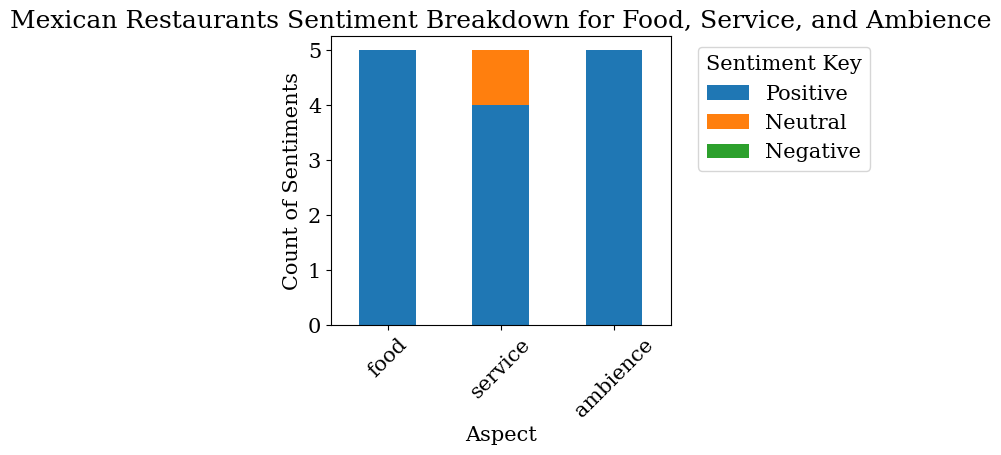

In [102]:
# Extract keys and create new columns
for key in sample2['absa_gen'][0].keys():
    sample2[key] = sample2['absa_gen'].apply(lambda x: x[key])

# Count occurrences of each sentiment for food, service, and ambience
sentiments = ['Positive', 'Neutral', 'Negative']
aspects = ['food', 'service', 'ambience']

# Initialize an empty dictionary to hold the sentiment counts
sentiment_counts = {aspect: {sentiment: 0 for sentiment in sentiments} for aspect in aspects}

# Populate the sentiment counts
for aspect in aspects:
    counts = sample2[aspect].value_counts()
    for sentiment in sentiments:
        if sentiment in counts:
            sentiment_counts[aspect][sentiment] = counts[sentiment]

# Create a DataFrame from sentiment counts
sentiment_df = pd.DataFrame(sentiment_counts)

# Plot the stacked bar chart
sentiment_df.T.plot(kind='bar', stacked=True)

# Customize the chart
plt.title('Mexican Restaurants Sentiment Breakdown for Food, Service, and Ambience')
plt.xlabel('Aspect')
plt.ylabel('Count of Sentiments')
plt.xticks(rotation=45)

# Place the legend outside the plot
plt.legend(title='Sentiment Key', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust the layout to make room for the legend
plt.tight_layout()

# Show the plot
plt.show()

# Add PyABSA on sample's reviews

In [103]:
# You can inference from a list of setences or a DatasetItem from PyABSA 
examples = ['Staff was very rude but food was delicious']
inference_source = examples
atepc_result = aspect_extractor.extract_aspect(inference_source=inference_source,  #
                          pred_sentiment=True,  # Predict the sentiment of extracted aspect terms
                          )

[2024-06-18 01:03:27] (2.4.1.post1) The results of aspect term extraction have been saved in /kaggle/working/Aspect Term Extraction and Polarity Classification.FAST_LCF_ATEPC.result.json
[2024-06-18 01:03:27] (2.4.1.post1) Example 0: Staff was very rude but <food:Positive Confidence:0.9994> was delicious


In [104]:
atepc_result[0].get('aspect')

['Staff', 'food']

In [105]:
atepc_result[0].get('sentiment')

['Negative', 'Positive']

In [106]:
dict(zip(atepc_result[0].get('aspect'), atepc_result[0].get('sentiment')))

{'Staff': 'Negative', 'food': 'Positive'}

In [107]:
test_d = dict(zip(atepc_result2[0].get('aspect'), atepc_result2[0].get('sentiment')))
test_d['music'] = 'Neutral'
test_d

{'ceviche': 'Positive',
 'portion': 'Positive',
 'flavors': 'Positive',
 'margarita mix': 'Positive',
 'it': 'Positive',
 'setting': 'Positive',
 'staff': 'Positive',
 'service': 'Positive',
 'music': 'Neutral'}

In [108]:
grouped_dict = {}

for key, value in test_d.items():
    if value not in grouped_dict:
        grouped_dict[value] = [key]
    else:
        grouped_dict[value].append(key)

# Convert keys into combined strings
grouped_dict = {", ".join(keys): value for value, keys in grouped_dict.items()}

grouped_dict

{'ceviche, portion, flavors, margarita mix, it, setting, staff, service': 'Positive',
 'music': 'Neutral'}

In [109]:
# Run Pandas review row through PyABSA
sample2.head(1)

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,categories,absa_gen,food,service,ambience
0,dpRQqEtOgefuSdwWv2nLCA,5.0,this is my second time here and the food is good. love the warm chips and salsa. happy to have a mexican restaurant in the neighborhood.,positive,0.996122,"Restaurants, Mexican","{'food': 'Positive', 'service': 'Positive', 'ambience': 'Positive'}",Positive,Positive,Positive


In [110]:
# Make sure new dict created with aspects and sentiments
def absa_sp(text):

    atepc_result = aspect_extractor.extract_aspect(inference_source=text,  #
                          pred_sentiment=True,  # Predict the sentiment of extracted aspect terms
                          )
    aspect = atepc_result[0].get('aspect')
    sentiment = atepc_result[0].get('sentiment')
    new_dict = dict(zip(sentiment, aspect)) #swap this to use chatgpt 3.5/try gemini
    
    grouped_dict = {} # Create final dictionary that aggregates words to grouped by sentiment

    for key, value in new_dict.items():
        if value not in grouped_dict:
            grouped_dict[value] = [key]
        else:
            grouped_dict[value].append(key)

    # Convert keys into combined strings
    grouped_dict = {", ".join(keys): value for value, keys in grouped_dict.items()}
    
    return grouped_dict


sample2['absa_sp'] = sample2['clean_text'].apply(lambda x: absa_sp([x]))

[2024-06-18 01:03:33] (2.4.1.post1) The results of aspect term extraction have been saved in /kaggle/working/Aspect Term Extraction and Polarity Classification.FAST_LCF_ATEPC.result.json
[2024-06-18 01:03:33] (2.4.1.post1) Example 0: this is my second time here and the <food:Positive Confidence:0.9984> is good . love the warm <chips and salsa:Positive Confidence:0.9995> . happy to have a mexican restaurant in the neighborhood .
[2024-06-18 01:03:36] (2.4.1.post1) The results of aspect term extraction have been saved in /kaggle/working/Aspect Term Extraction and Polarity Classification.FAST_LCF_ATEPC.result.json
[2024-06-18 01:03:36] (2.4.1.post1) Example 0: had to stop into an alternate business across the road on a saturday morning ( 1 aug 2020 ) and had to hit a breakfast joint up - los betos was the spot ! first thing that i want to recognize is the incredible timeline this place is open : mon - sat 0430 - 1000 pm ! ? then sunday from 0700 - 0600 pm . really going the distance here 

In [111]:
sample2.head()

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,categories,absa_gen,food,service,ambience,absa_sp
0,dpRQqEtOgefuSdwWv2nLCA,5.0,this is my second time here and the food is good. love the warm chips and salsa. happy to have a mexican restaurant in the neighborhood.,positive,0.996122,"Restaurants, Mexican","{'food': 'Positive', 'service': 'Positive', 'ambience': 'Positive'}",Positive,Positive,Positive,{'Positive': 'chips and salsa'}
1,3rJqrzmT02RxDLWMhdm9gg,5.0,"had to stop into an alternate business across the road on a saturday morning (1 aug 2020) and had to hit a breakfast joint up - los betos was the spot! first thing that i want to recognize is the incredible timeline this place is open: mon-sat 0430-1000 pm!? then sunday from 0700-0600 pm. really going the distance here to make the availability to be open so for that, i'm quite impressed! second, the food is hot, fresh, delicious and fast! really gotta shout out that this food is delish. had a 'supreme' burrito and it was finger-licking darn delish!! drinks are not self serve through covid-19 at the moment but a large drink only costs you $2.00 seating is situated so you're about 6 feet apart as well. and, a popular mexican cable music channel is broadcasted on a little 32"" tv hanging on the wall. the store wasn't messy or smelly, but the look of it was a bit rough and weathered. half the lights didn't illuminate, can't discern if the surfaces where sanitized and the overall look was again, just rough. please don't look down too much on that but it is note worthy. personally, my family and i love dives per se; you can normally find some of the most humble restaurants and even better food. gripe time. not a fan of restaurants shutting down restrooms for 'covid'. there just isn't enough speaking power to present a convincing stance to me that this needs to be done. it restricts people under emergencies and with medical issues alongside with making the whole experience just better so you can wash your hands afterwards (or before for sanitation!) i'm not a fan of businesses that do this and they do here... overall, delicious food and grateful they're open and if you're in a hurry, the drive-through rocks too!!",positive,0.604875,"Restaurants, Mexican","{'food': 'Positive', 'service': 'Positive', 'ambience': 'Positive'}",Positive,Positive,Positive,{}
2,wVhmXDEAyMidEJyHmgT31A,5.0,went to dinner with family. ordered a combination plate with two tacos one green corn tamale and refried beans.it was so delicious and their services we're great and a great margarita service was aweaome,positive,0.997619,"Restaurants, Mexican","{'food': 'Positive', 'service': 'Positive', 'ambience': 'Positive'}",Positive,Positive,Positive,"{'Neutral': 'dinner', 'Positive': 'margarita'}"
3,ItgdW1pvPf11kRdw4FRHtQ,5.0,"delicious authentic mexican food. tacos are served on homemade tortillas and the salsa's are bomb. p.s. they only take cash. but that's no problem, take my wallet! lol",positive,0.997352,"Restaurants, Mexican","{'food': 'Positive', 'service': 'Neutral', 'ambience': 'Positive'}",Positive,Neutral,Positive,"{'Positive': 'tacos', 'Neutral': 'served'}"
4,5E51bRZaFFTq2dCKfy49Ig,4.0,"was recommended to go here and am happy i did! this place is overall very delicious. probably the best horchata i've ever had, and the guacamole and all the food was really good. loved:horchataguacamole (wish there was more, we finished the plate quickly!)lornito suizo (thought that it would be a lot bigger, but is actually very small)super-rica especial didn't love:the long wait in the hot suncash onlylimited seatingsmall portions",positive,0.994921,"Restaurants, Mexican","{'food': 'Positive', 'service': 'Positive', 'ambience': 'Positive'}",Positive,Positive,Positive,"{'Positive': 'food', 'Negative': 'portions'}"


In [112]:
# Function to expand absa_sp dictionary into separate columns
def expand_absa_sp(row):
    result = {}
    for key, value in row.items():
        result[key] = value
    return pd.Series(result)

# Apply the function to the absa_sp column
expanded_columns = sample2['absa_sp'].apply(expand_absa_sp)

# Concatenate the original DataFrame with the expanded columns
sample2 = pd.concat([sample2, expanded_columns], axis=1)

# Change NaN to None 
sample2 = sample2.replace({np.nan: None})
sample2

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,categories,absa_gen,food,service,ambience,absa_sp,Positive,Neutral,Negative
0,dpRQqEtOgefuSdwWv2nLCA,5.0,this is my second time here and the food is good. love the warm chips and salsa. happy to have a mexican restaurant in the neighborhood.,positive,0.996122,"Restaurants, Mexican","{'food': 'Positive', 'service': 'Positive', 'ambience': 'Positive'}",Positive,Positive,Positive,{'Positive': 'chips and salsa'},chips and salsa,None,None
1,3rJqrzmT02RxDLWMhdm9gg,5.0,"had to stop into an alternate business across the road on a saturday morning (1 aug 2020) and had to hit a breakfast joint up - los betos was the spot! first thing that i want to recognize is the incredible timeline this place is open: mon-sat 0430-1000 pm!? then sunday from 0700-0600 pm. really going the distance here to make the availability to be open so for that, i'm quite impressed! second, the food is hot, fresh, delicious and fast! really gotta shout out that this food is delish. had a 'supreme' burrito and it was finger-licking darn delish!! drinks are not self serve through covid-19 at the moment but a large drink only costs you $2.00 seating is situated so you're about 6 feet apart as well. and, a popular mexican cable music channel is broadcasted on a little 32"" tv hanging on the wall. the store wasn't messy or smelly, but the look of it was a bit rough and weathered. half the lights didn't illuminate, can't discern if the surfaces where sanitized and the overall look was again, just rough. please don't look down too much on that but it is note worthy. personally, my family and i love dives per se; you can normally find some of the most humble restaurants and even better food. gripe time. not a fan of restaurants shutting down restrooms for 'covid'. there just isn't enough speaking power to present a convincing stance to me that this needs to be done. it restricts people under emergencies and with medical issues alongside with making the whole experience just better so you can wash your hands afterwards (or before for sanitation!) i'm not a fan of businesses that do this and they do here... overall, delicious food and grateful they're open and if you're in a hurry, the drive-through rocks too!!",positive,0.604875,"Restaurants, Mexican","{'food': 'Positive', 'service': 'Positive', 'ambience': 'Positive'}",Positive,Positive,Positive,{},None,None,None
2,wVhmXDEAyMidEJyHmgT31A,5.0,went to dinner with family. ordered a combination plate with two tacos one green corn tamale and refried beans.it was so delicious and their services we're great and a great margarita service was aweaome,positive,0.997619,"Restaurants, Mexican","{'food': 'Positive', 'service': 'Positive', 'ambience': 'Positive'}",Positive,Positive,Positive,"{'Neutral': 'dinner', 'Positive': 'margarita'}",margarita,dinner,None
3,ItgdW1pvPf11kRdw4FRHtQ,5.0,"delicious authentic mexican food. tacos are served on homemade tortillas and the salsa's are bomb. p.s. they only take cash. but that's no problem, take my wallet! lol",positive,0.997352,"Restaurants, Mexican","{'food': 'Positive', 'service': 'Neutral', 'ambience': 'Positive'}",Positive,Neutral,Positive,"{'Positive': 'tacos', 'Neutral': 'served'}",tacos,served,None
4,5E51bRZaFFTq2dCKfy49Ig,4.0,"was recommended to go here and am happy i did! this place is overall very delicious. probably the best horchata i've ever had, and the guacamole and all the food was really good. loved:horchataguacamole (wish there was more, we finished the plate quickly!)lornito suizo (thought that it would be a lot bigger, but is actually very small)super-rica especial didn't love:the long wait in the hot suncash onlylimited seatingsmall portions",positive,0.994921,"Restaurants, Mexican","{'food': 'Positive', 'service': 'Positive', 'ambience': 'Positive'}",Positive,Positive,Positive,"{'Positive': 'food', 'Negative': 'portions'}",food,None,portions


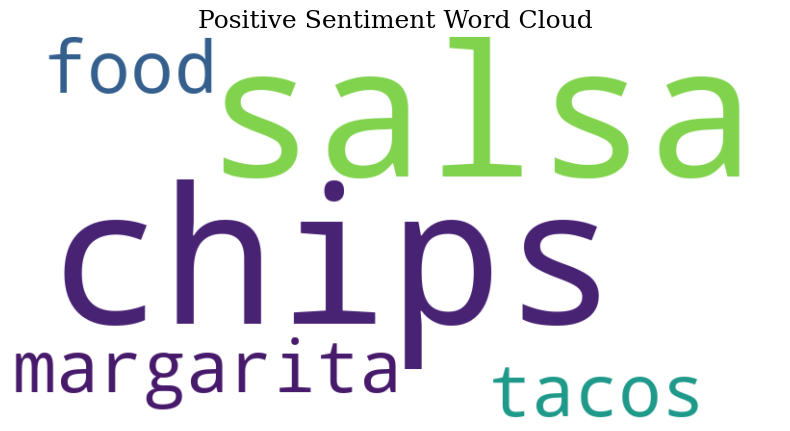

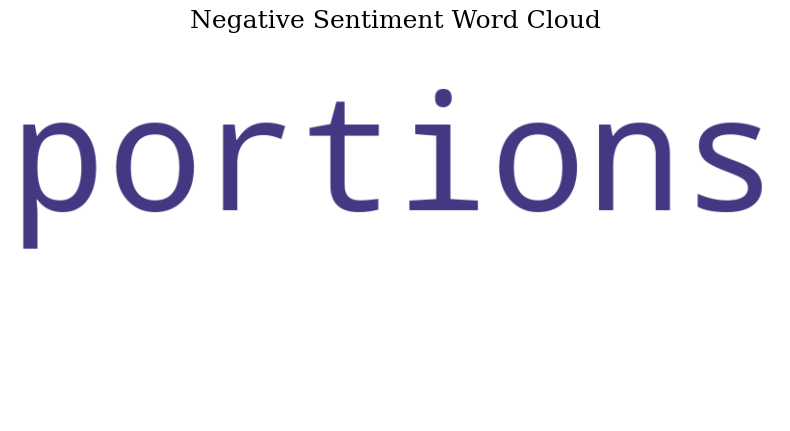

In [113]:
# Create wordclouds for each sentiment

# Function to generate word cloud
def generate_wordcloud(column_data, title):
    text = ' '.join(filter(None, column_data))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Generate word clouds for each sentiment
generate_wordcloud(sample2['Positive'], 'Positive Sentiment Word Cloud')
# generate_wordcloud(sample2['Neutral'], 'Neutral Sentiment Word Cloud')
generate_wordcloud(sample2['Negative'], 'Negative Sentiment Word Cloud')

### Can create recommendations for restaurants on what they have been doing well and room for improvement

Looks like Mexican restaurants are doing well with: green salsa and tacos and  need to work on: the beer, salsa and environment. 

# Emotion classification (using HF pipe)

In [114]:
sample2.head(1)

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,categories,absa_gen,food,service,ambience,absa_sp,Positive,Neutral,Negative
0,dpRQqEtOgefuSdwWv2nLCA,5.0,this is my second time here and the food is good. love the warm chips and salsa. happy to have a mexican restaurant in the neighborhood.,positive,0.996122,"Restaurants, Mexican","{'food': 'Positive', 'service': 'Positive', 'ambience': 'Positive'}",Positive,Positive,Positive,{'Positive': 'chips and salsa'},chips and salsa,None,None


In [115]:
emotion_model = pipeline(model="bhadresh-savani/distilbert-base-uncased-emotion")
sample2 = (
sample2.assign(emotion1 = lambda x: x['clean_text'].apply(lambda s: emotion_model(s)))
    .assign(
         emotion = lambda x: x['emotion1'].apply(lambda s: (s[0]['label']))
    )
)

sample2.drop(columns=['emotion1'], inplace=True)
sample2.head()

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


config.json:   0%|          | 0.00/768 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,categories,absa_gen,food,service,ambience,absa_sp,Positive,Neutral,Negative,emotion
0,dpRQqEtOgefuSdwWv2nLCA,5.0,this is my second time here and the food is good. love the warm chips and salsa. happy to have a mexican restaurant in the neighborhood.,positive,0.996122,"Restaurants, Mexican","{'food': 'Positive', 'service': 'Positive', 'ambience': 'Positive'}",Positive,Positive,Positive,{'Positive': 'chips and salsa'},chips and salsa,None,None,joy
1,3rJqrzmT02RxDLWMhdm9gg,5.0,"had to stop into an alternate business across the road on a saturday morning (1 aug 2020) and had to hit a breakfast joint up - los betos was the spot! first thing that i want to recognize is the incredible timeline this place is open: mon-sat 0430-1000 pm!? then sunday from 0700-0600 pm. really going the distance here to make the availability to be open so for that, i'm quite impressed! second, the food is hot, fresh, delicious and fast! really gotta shout out that this food is delish. had a 'supreme' burrito and it was finger-licking darn delish!! drinks are not self serve through covid-19 at the moment but a large drink only costs you $2.00 seating is situated so you're about 6 feet apart as well. and, a popular mexican cable music channel is broadcasted on a little 32"" tv hanging on the wall. the store wasn't messy or smelly, but the look of it was a bit rough and weathered. half the lights didn't illuminate, can't discern if the surfaces where sanitized and the overall look was again, just rough. please don't look down too much on that but it is note worthy. personally, my family and i love dives per se; you can normally find some of the most humble restaurants and even better food. gripe time. not a fan of restaurants shutting down restrooms for 'covid'. there just isn't enough speaking power to present a convincing stance to me that this needs to be done. it restricts people under emergencies and with medical issues alongside with making the whole experience just better so you can wash your hands afterwards (or before for sanitation!) i'm not a fan of businesses that do this and they do here... overall, delicious food and grateful they're open and if you're in a hurry, the drive-through rocks too!!",positive,0.604875,"Restaurants, Mexican","{'food': 'Positive', 'service': 'Positive', 'ambience': 'Positive'}",Positive,Positive,Positive,{},None,None,None,surprise
2,wVhmXDEAyMidEJyHmgT31A,5.0,went to dinner with family. ordered a combination plate with two tacos one green corn tamale and refried beans.it was so delicious and their services we're great and a great margarita service was aweaome,positive,0.997619,"Restaurants, Mexican","{'food': 'Positive', 'service': 'Positive', 'ambience': 'Positive'}",Positive,Positive,Positive,"{'Neutral': 'dinner', 'Positive': 'margarita'}",margarita,dinner,None,joy
3,ItgdW1pvPf11kRdw4FRHtQ,5.0,"delicious authentic mexican food. tacos are served on homemade tortillas and the salsa's are bomb. p.s. they only take cash. but that's no problem, take my wallet! lol",positive,0.997352,"Restaurants, Mexican","{'food': 'Positive', 'service': 'Neutral', 'ambience': 'Positive'}",Positive,Neutral,Positive,"{'Positive': 'tacos', 'Neutral': 'served'}",tacos,served,None,joy
4,5E51bRZaFFTq2dCKfy49Ig,4.0,"was recommended to go here and am happy i did! this place is overall very delicious. probably the best horchata i've ever had, and the guacamole and all the food was really good. loved:horchataguacamole (wish there was more, we finished the plate quickly!)lornito suizo (thought that it would be a lot bigger, but is actually very small)super-rica especial didn't love:the long wait in the hot suncash onlylimited seatingsmall portions",positive,0.994921,"Restaurants, Mexican","{'food': 'Positive', 'service': 'Positive', 'ambience': 'Positive'}",Positive,Positive,Positive,"{'Positive': 'food', 'Negative': 'portions'}",food,None,portions,joy


Mostly accurate. 1/5 has wrong emotion classification.

# Named Entity Recognition (to categorize reviews to certain location/food)

# Radar Graph between 2 similar, close in proximity restaurants 